In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import pickle
import os,sys
import pyxdf as xdf
import torch
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import mean_squared_error
sys.path.append("../models/model_based_files/")
#sys.path.append("../models/Data_based_models/transformer_1/")
sys.path.append("../models/Data_based_models/ResNet/")
from Speed_Recognition_3 import SpeedRecProcessing as SRP
from model_2 import Speed_model_2 as SP
from model2 import CNN as CLSTM
from model2 import ResidualBlock as RB
#from model2 import CNN_LSTM as CLSTM
from preprocessing1 import preprocess,split
from dataset import IMU

/home/prestige/Documents/venvs/activity_class/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
sns.set_color_codes('dark')
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('lines', linewidth=1.5)
plt.rc('font', size=25)          # controls default text sizes

In [9]:
t=np.arange(0,1,1/200)
time=np.repeat(t,3,axis=0).reshape(3,1,200)
print(time.shape)
#plt.plot(time[1,:])

(3, 1, 200)


# Directory Information


In [2]:
sub_1=os.listdir("../Recordings/sub-P001/")
sub_2=os.listdir("../Recordings/sub-P002/")
sub_3=os.listdir("../Recordings/sub-P003/")
sub_5=os.listdir("../Recordings/sub-P005/")

print(sub_1)
print(sub_2)
print(sub_3)
print(sub_5)

['sub-P001_ses-S001_task-Default_run-011_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-001_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-013_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-009_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-003_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-010_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-008_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-002_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-005_eeg.xdf', 'aug_data', 'sub-P001_ses-S001_task-Default_run-006_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-004_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-007_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-012_eeg.xdf']
['sub-P001_ses-S001_task-Default_run-011_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-001_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-013_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-009_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-003_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-010_eeg.xdf', 'sub-P001_ses-S001_task-Default_run-

In [5]:
sub_7=os.listdir("../Recordings/sub-P007/Session_2")

In [3]:
ds=[]
dst=[]
acc=[]
acct=[]

for i,file in enumerate(sub_6):

    data,header=xdf.load_xdf('../Recordings/sub-P006/Session1/'+file)
    for stream in data:
  
            if stream['info']['name'][0]=='TestInf':
                ds.append(stream['time_series'])
                dst.append(stream['time_stamps'])
            if stream['info']['name'][0]=='polar accel':
                acc.append(stream['time_series'])
                acct.append(stream['time_stamps'])
                print(stream['time_series'].shape)
           

(144384, 3)
(36352, 3)
(14592, 3)
(68096, 3)
(92896, 3)
(144384, 3)
(18784, 3)
(88128, 3)
(83936, 3)
(40512, 3)
(82176, 3)
(81248, 3)
(144864, 3)


In [30]:
print(acc[0][:,0])

[-926. -915. -913. ... -990. -986. -988.]


In [31]:
df1_dct={'data':ds[0],'time':dst[0]}
df1=pd.DataFrame(df1_dct)
df1_dcta={'acc_z':acc[0][:,0],'acc_x':acc[0][:,1],'acc_y':acc[0][:,2],'time_acc':acct[0]}
df1a=pd.DataFrame(df1_dcta)


In [47]:
print(acct[-2])

[1813625.15280667 1813625.15781664 1813625.16282661 ... 1814066.65610015
 1814066.66111012 1814066.66612008]


In [4]:
for i in range(len(dst)):
    try:
        dst[i]=dst[i]-dst[i][0]
        acct[i]=acct[i]-acct[i][0]
    except:
        print(i,dst[i],acct[i])
        acct[i]=acct[i]-acct[i][0]        


2 [] [1822690.34249198 1822690.34750178 1822690.35251158 ... 1822763.43047061
 1822763.43548041 1822763.44049021]


In [5]:
ds.pop(2)
dst.pop(2)
acc.pop(2)
acct.pop(2)

array([0.00000000e+00, 5.00980043e-03, 1.00196009e-02, ...,
       7.30879786e+01, 7.30929884e+01, 7.30979982e+01])

In [6]:
sp_acc={'msg':[[] for i in range(len(dst))],'data':[[] for i in range(len(dst))]}
prev_i=0
prev_j=0

for k in range(len(dst)):
    for j,value in enumerate(dst[k]):
        for i,v in enumerate(acct[k]):
            if v>value:
                sp_acc['msg'][k].append(ds[k][j])
                sp_acc['data'][k].append(acc[k][prev_i:i,:])
                if j+1==len(dst[k]):
                    sp_acc['data'][k].append(acc[k][i:,:])
                prev_i=i
                break





In [7]:
for i in range(12):
    sp_acc['data'][i].pop(0)

In [2]:
sub_6=os.listdir("../Recordings/Testing_sub-P001/")

# Simulations and plotting


2023-05-02 20:43:01.517 (1114.230s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:01.517 (1114.230s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:43:01.517 (1114.230s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:43:01.517 (1114.230s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:01.517 

[['S002,2000-01-01,,,S002_Standing,,EMG calibration']]


/home/prestige/Documents/GitHub/Thesis_Speed_estimation/Processing/../models/model_based_files/Speed_Recognition_3.py:145: RuntimeWarning: invalid value encountered in sqrt
  delta_x = np.sqrt(self.h**2-(self.h-del_y)**2)*0.01


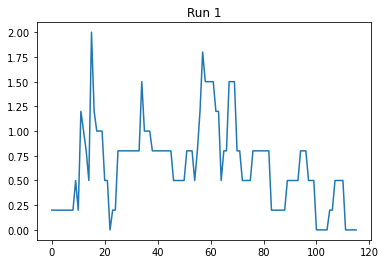

2023-05-02 20:43:02.837 (1115.549s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:02.837 (1115.550s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:43:02.837 (1115.550s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:43:02.837 (1115.550s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:02.837 

[['S002,2023-04-26,,27,S002_Optimization_22,,Re-do optimization 22'], ['S002,2023-04-26,,27,S002_Optimization_22,,First iteration'], ['S002,2023-04-26,,27,S002_Optimization_22,,Second iteration'], ['S002,2023-04-26,,27,S002_Optimization_22,,Third parameter'], ['S002,2023-04-26,,27,S002_Optimization_22,,Third parameter'], ['S002,2023-04-26,,27,S002_Optimization_22,,Fourth parameter'], ['S002,2023-04-26,,27,S002_Optimization_22,,Fifth parameter'], ['S002,2023-04-26,,27,S002_Optimization_22,,Sixth parameter'], ['S002,2023-04-26,,27,S002_Optimization_22,,Sixth parameter'], ['S002,2023-04-26,,27,S002_Optimization_22,,Seventh parameter'], ['S002,2023-04-26,,27,S002_Optimization_22,,end']]


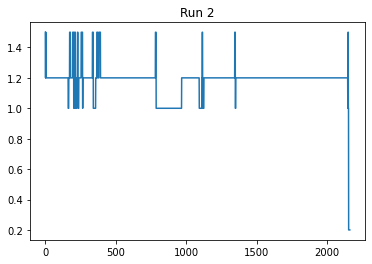

2023-05-02 20:43:15.912 (1128.625s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:15.913 (1128.625s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:43:15.913 (1128.625s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:43:15.913 (1128.626s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:15.913 

[['S002,2000-01-01,,,S002_Standing,,Standing']]


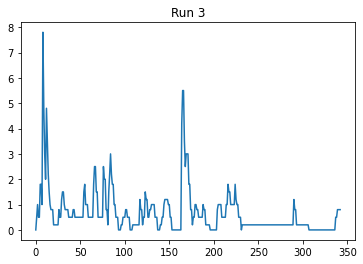

2023-05-02 20:43:18.599 (1131.312s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:18.599 (1131.312s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:43:18.599 (1131.312s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:43:18.599 (1131.312s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:18.599 

[['S002,2023-04-26,,27,S002_Optimization_22,,Low torque warmup '], ['S002,2023-04-26,,27,S002_Optimization_22,,High torque']]


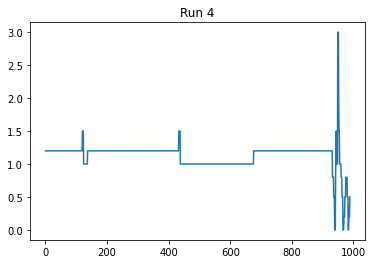

2023-05-02 20:43:24.770 (1137.483s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:24.770 (1137.483s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:43:24.770 (1137.483s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:43:24.770 (1137.483s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:24.770 

[['S002,2023-04-26,,27,S002_Optimization_28,,warmup'], ['S002,2023-04-26,,27,S002_Optimization_28,,second'], ['S002,2023-04-26,,27,S002_Optimization_28,,third'], ['S002,2023-04-26,,27,S002_Optimization_28,,fourth'], ['S002,2023-04-26,,27,S002_Optimization_28,,fourth'], ['S002,2023-04-26,,27,S002_Optimization_28,,fifth'], ['S002,2023-04-26,,27,S002_Optimization_28,,6th'], ['S002,2023-04-26,,27,S002_Optimization_28,,7th'], ['S002,2023-04-26,,27,S002_Optimization_28,,7th']]


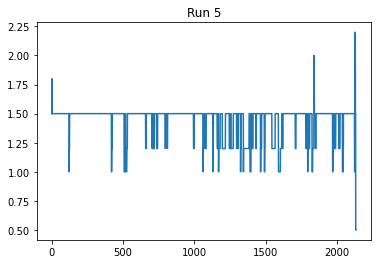

2023-05-02 20:43:37.979 (1150.692s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:37.979 (1150.692s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:43:37.979 (1150.692s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:43:37.979 (1150.692s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:37.979 

[['S002,2023-04-26,,27,S002_Optimization_22,,warm up'], ['S002,2023-04-26,,27,S002_Optimization_28,,warm up'], ['S002,2023-04-26,,27,S002_Optimization_28,,first parameter'], ['S002,2023-04-26,,27,S002_Optimization_28,,second parameter'], ['S002,2023-04-26,,27,S002_Optimization_28,,third parameter'], ['S002,2023-04-26,,27,S002_Optimization_28,,third parameter']]


Stream 2: Calculated effective sampling rate 2262.5075 Hz is different from specified rate 1926.0000 Hz.


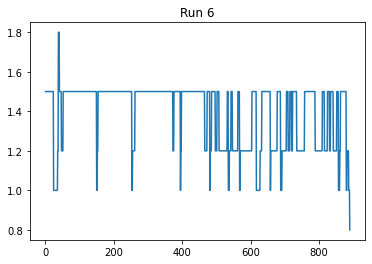

2023-05-02 20:43:43.947 (1156.659s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:43.947 (1156.660s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:43:43.947 (1156.660s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:43:43.947 (1156.660s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:43.947 

[['S002,2023-04-26,,27,S002_Optimization_30,,warmup'], ['S002,2023-04-26,,27,S002_Optimization_30,,first'], ['S002,2023-04-26,,27,S002_Optimization_30,,second'], ['S002,2023-04-26,,27,S002_Optimization_30,,third'], ['S002,2023-04-26,,27,S002_Optimization_30,,third'], ['S002,2023-04-26,,27,S002_Optimization_30,,4th'], ['S002,2023-04-26,,27,S002_Optimization_30,,5th'], ['S002,2023-04-26,,27,S002_Optimization_30,,6th']]


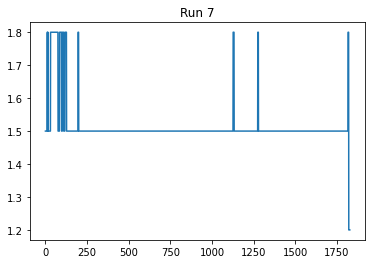

2023-05-02 20:43:54.813 (1167.526s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:54.813 (1167.526s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:43:54.813 (1167.526s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:43:54.813 (1167.526s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:54.813 

[['S002,2023-04-26,,27,S002_Validation_Block_2_Generic_22,,generic 1m/s'], ['S002,2023-04-26,,27,S002_Validation_Block_2_Generic_22,,high torque generic 1m/s']]


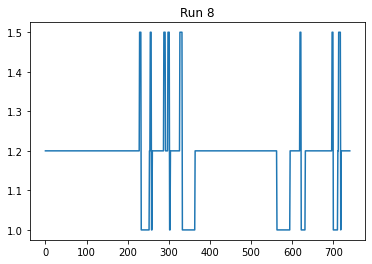

2023-05-02 20:43:59.551 (1172.264s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:59.551 (1172.264s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:43:59.551 (1172.264s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:43:59.551 (1172.264s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:43:59.551 

[['S002,2023-04-26,,27,S002_Validation_Block_2_Generic_28,,generic 1.25m/s']]


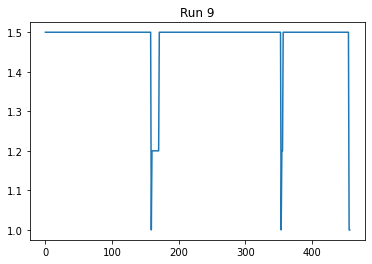

2023-05-02 20:44:02.915 (1175.628s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:02.915 (1175.628s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:44:02.915 (1175.628s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:44:02.915 (1175.628s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:02.915 

[]


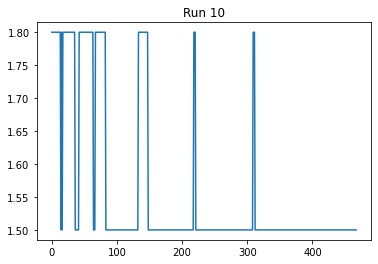

2023-05-02 20:44:06.356 (1179.069s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:06.356 (1179.069s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:44:06.356 (1179.069s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:44:06.356 (1179.069s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:06.356 

[['S002,2023-04-26,,27,S002_Validation_Block_3_Optimal_22,,optimal day 1 1m/s ']]


Stream 4: Calculated effective sampling rate 2333.4494 Hz is different from specified rate 1926.0000 Hz.


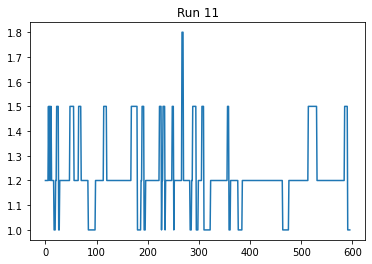

2023-05-02 20:44:10.345 (1183.058s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:10.345 (1183.058s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:44:10.345 (1183.058s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:44:10.345 (1183.058s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:10.345 

[['S002,2023-04-26,,27,S002_Validation_Block_3_Optimal_22,,optimal day 1 1m/s ']]


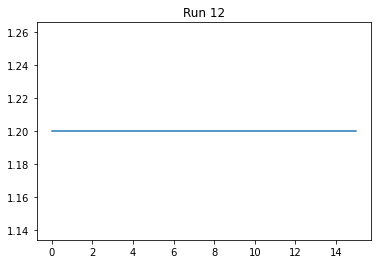

2023-05-02 20:44:11.076 (1183.789s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:11.076 (1183.789s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:44:11.077 (1183.789s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:44:11.077 (1183.789s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:11.077 

[]


Stream 4: Calculated effective sampling rate 2345.9430 Hz is different from specified rate 1926.0000 Hz.


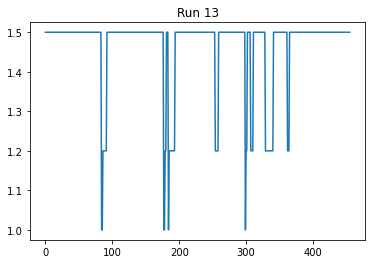

2023-05-02 20:44:14.437 (1187.150s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:14.437 (1187.150s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:44:14.438 (1187.150s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:44:14.438 (1187.150s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:14.438 

[]


Stream 10: Calculated effective sampling rate 2177.7360 Hz is different from specified rate 1926.0000 Hz.


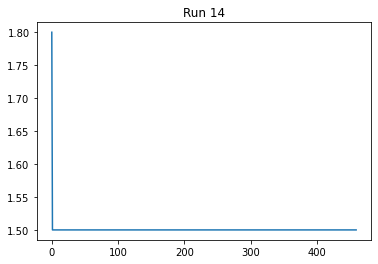

2023-05-02 20:44:17.666 (1190.379s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:17.666 (1190.379s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:44:17.666 (1190.379s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:44:17.666 (1190.379s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:17.666 

[['S002,2023-04-26,,27,S002_Validation_Block_1_Unpowered_22,,1m/s ']]


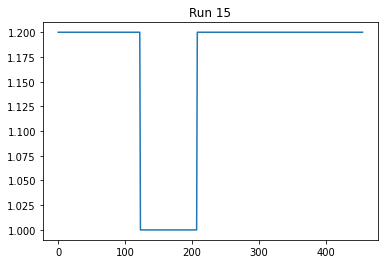

2023-05-02 20:44:20.890 (1193.603s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:20.890 (1193.603s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:44:20.890 (1193.603s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:44:20.890 (1193.603s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:20.890 

[]


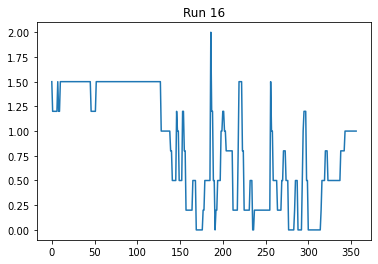

2023-05-02 20:44:23.405 (1196.118s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:23.405 (1196.118s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:44:23.405 (1196.118s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:44:23.405 (1196.118s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:23.406 

[['S002,2023-04-26,,27,S002_Validation_Block_1_Unpowered_28,,1.25m/s -delete previous']]


Stream 4: Calculated effective sampling rate 2573.1930 Hz is different from specified rate 1926.0000 Hz.


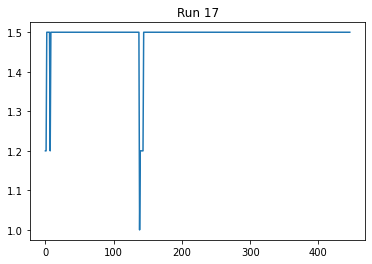

2023-05-02 20:44:25.070 (1197.783s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:25.070 (1197.783s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:44:25.070 (1197.783s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:44:25.070 (1197.783s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:25.071 

[['S002,2023-04-26,,27,S002_Validation_Block_1_Unpowered_33,,1.5m/s - zero torque']]


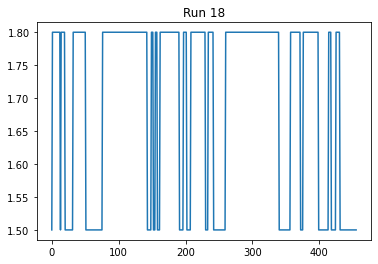

2023-05-02 20:44:28.376 (1201.089s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:28.376 (1201.089s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:7246:405e:e84d:ef0d (Address already in use)
2023-05-02 20:44:28.376 (1201.089s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::41c3:d5af:4c17:6a71%wlo1 (Address already in use)
2023-05-02 20:44:28.376 (1201.089s) [python          ]         udp_server.cpp:82    WARN| Could not bind multicast responder for ff05:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2601:241:8200:b100:e2eb:6b88:8eda:bfc4 (Address already in use)
2023-05-02 20:44:28.376 

[]


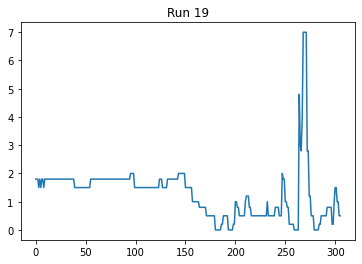

In [4]:
for i in range(1,20):
    x1=SRP(h=110,c=1.5)
    file=f'../Recordings/sub-P0010/Session_2/sub-P002_ses-S002_task-Default_run-00{i}_eeg.xdf'
    data,header=xdf.load_xdf(file)
    for stream in data:
        if stream['info']['name'][0]=='TestInf':
            print(stream['time_series'])
    data=x1.Speed_estimation_simulation(filepath=file,r_number=0.25)
    plt.figure()
    plt.plot(data['Double'])
    plt.title(f'Run {i}')
    plt.show()

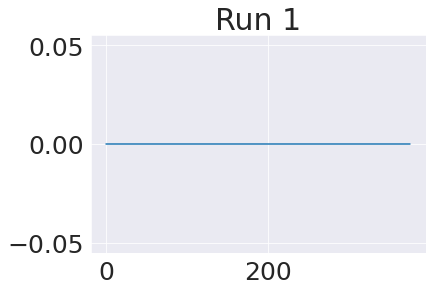

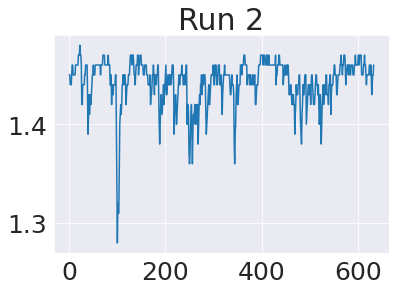

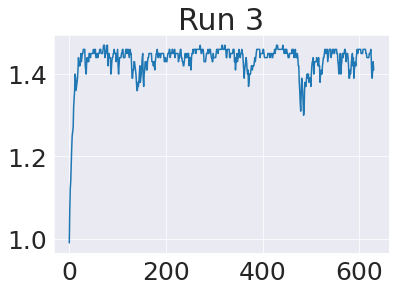

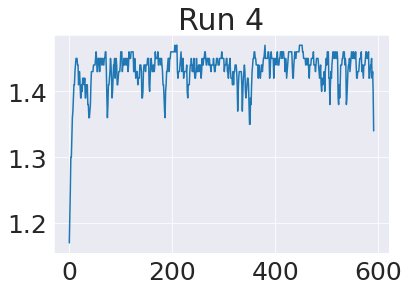

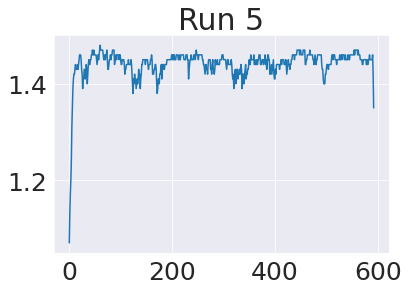

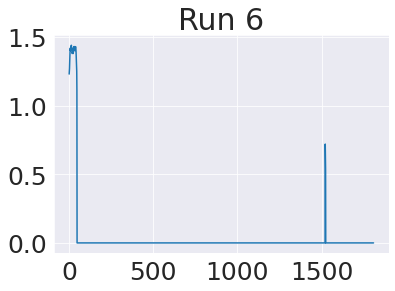

Run 7 failed


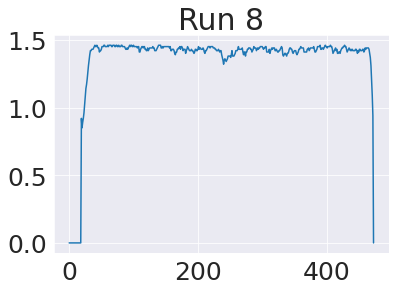

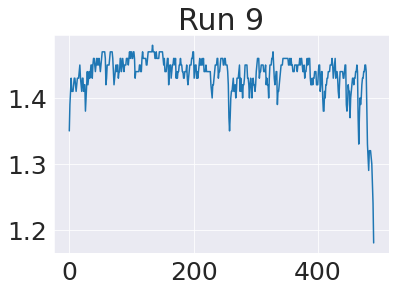

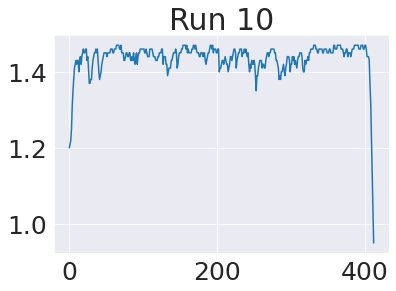

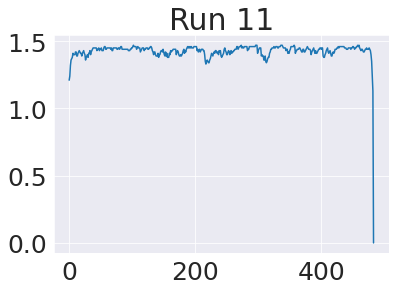

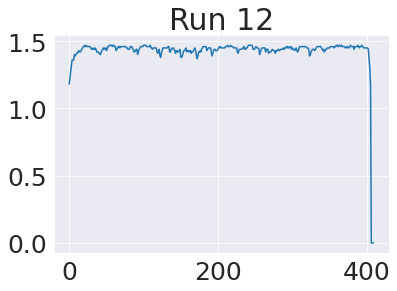

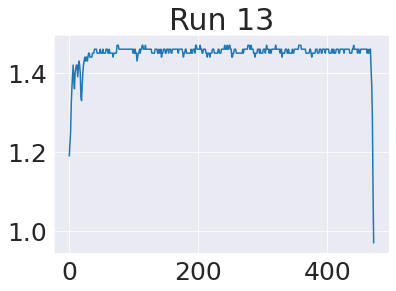

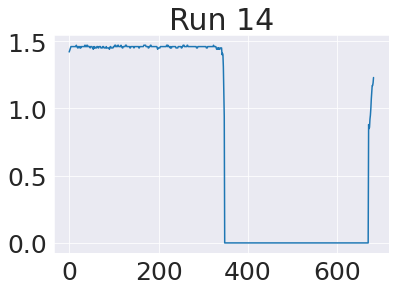

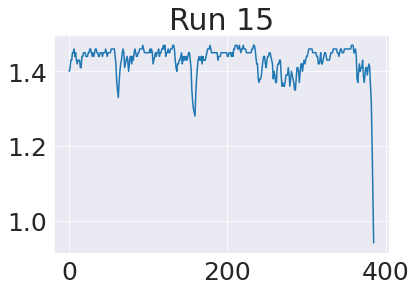

In [4]:
for i in range(1,16):
    try:
        file=f'../Recordings/sub-P0010/Session2/sub-P001_ses-S002_task-Default_run-00{i}_eeg.xdf'
        data,header=xdf.load_xdf(file)
        for stream in data:
            if stream['info']['name'][0]=='Speed':
                speeds=stream['time_series']
                plt.plot(speeds)
                plt.title(f'Run {i}')
                plt.show()
    except:
        print(f'Run {i} failed')

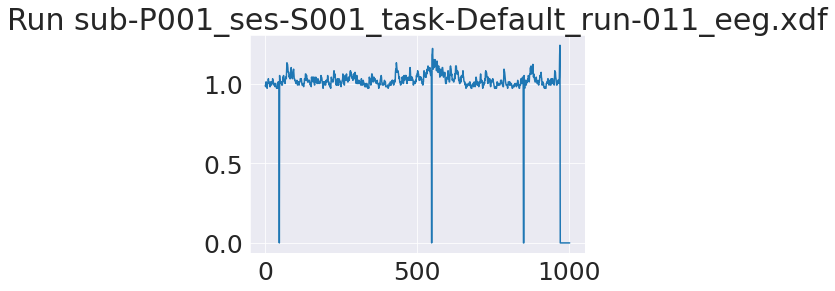

Run 1 failed


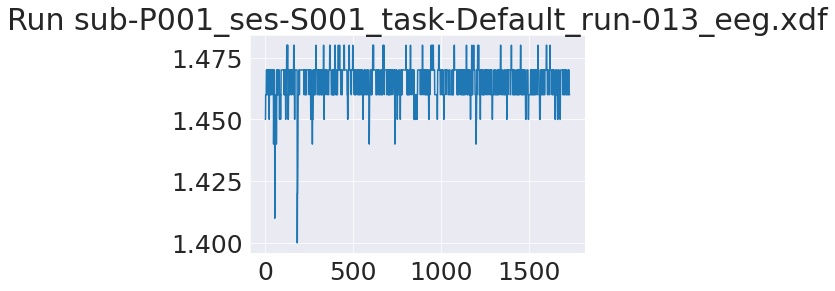

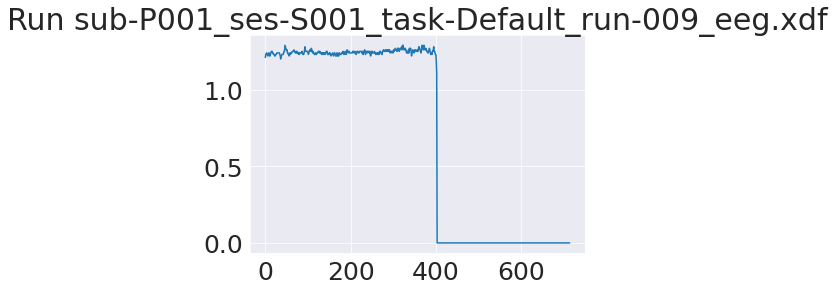

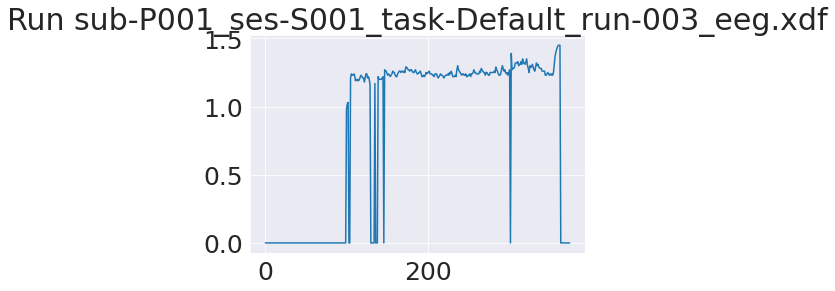

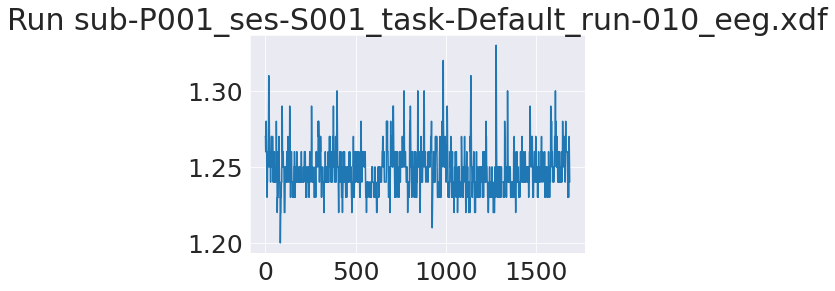

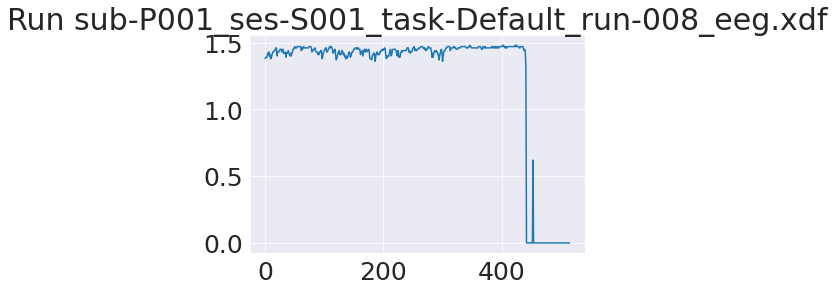

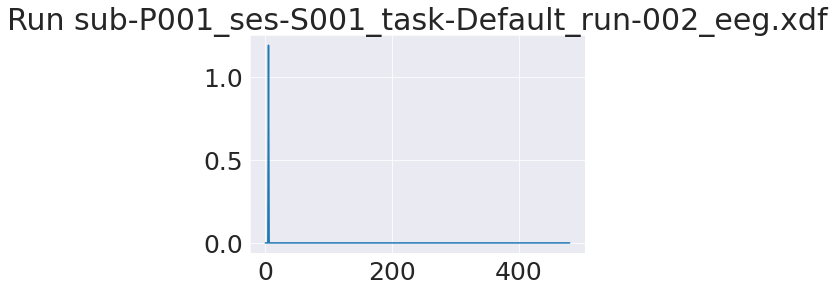

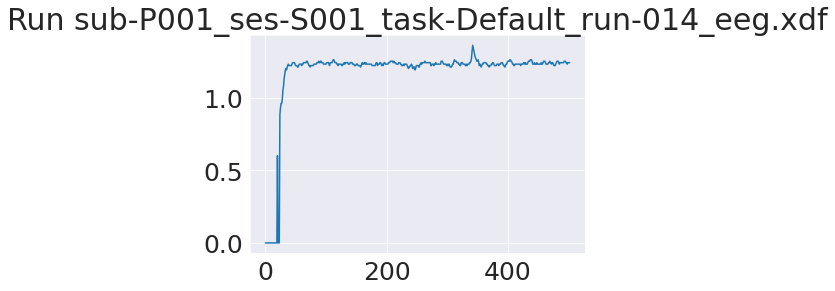

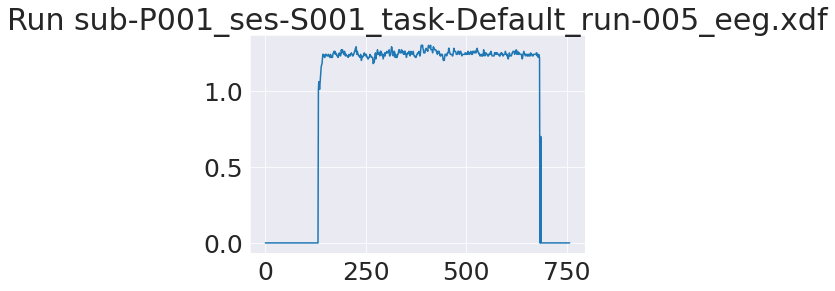

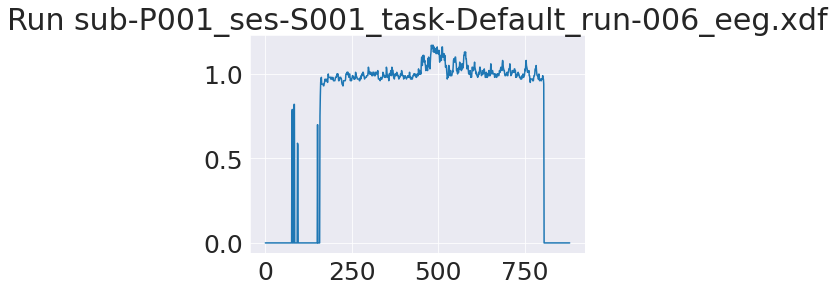

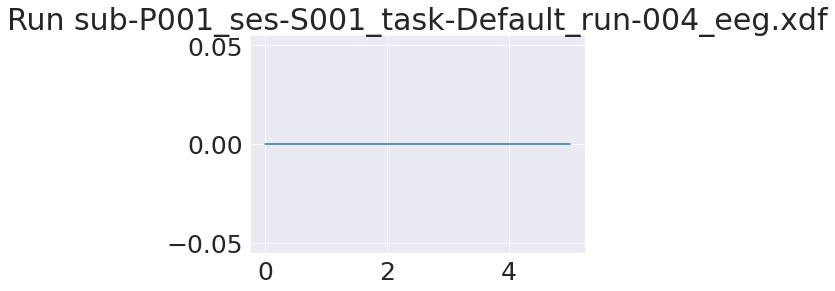

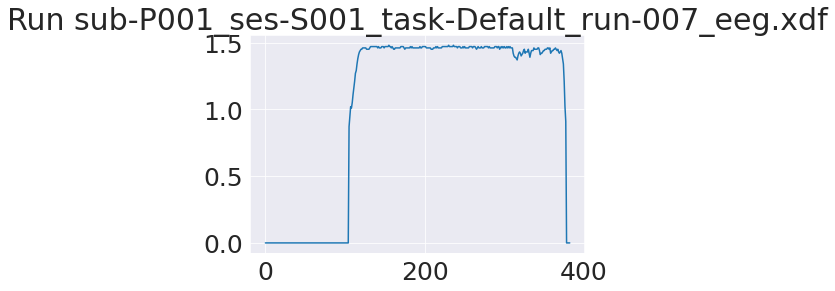

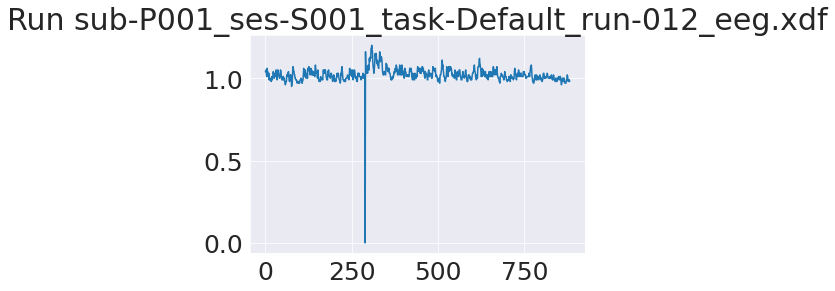

Run 16 failed


In [4]:
files=os.listdir('../Recordings/ARL_Sub01/Day01/')

for i,file in enumerate(files):
    try:
        data,header=xdf.load_xdf('../Recordings/ARL_Sub01/Day01/'+file)
        for stream in data:
            if stream['info']['name'][0]=='Speed':
                plt.plot(stream['time_series'])
                plt.title(f'Run {file}')
                plt.show()
    except:
        print(f'Run {i} failed')

# Data Prep


In [17]:
run=14
path=f'../Recordings/ARL_Sub01/Day01/sub-P001_ses-S001_task-Default_run-0{run}_eeg.xdf'
#path1='../Recordings/sub-P003/sub-P002_ses-S002_task-Default_run-007_eeg_old1.xdf'
streams, fileheader = xdf.load_xdf(path)
for stream in streams:
    print(stream['info']['name'][0])
    if stream['info']['name'][0]=='polar accel':
        print('here')
        data=stream['time_series']
        print(data.shape)
        length=data.shape[0]
        data=data[int(0.25*length):int(0.95*length),:]
        label=1 
        dic={'data':data,'label':label}
with open(f'../Recordings/ARL_Sub01/Day01/pickled_data/{run}.pickle','wb') as f:
    pickle.dump(dic,f)

Speed
Activity
polar accel
here
(50220, 3)
test
ECG_processed
Vicon Monitor
polar ECG
TestInf


# Data Loading


In [6]:
run=10
path=f'../Recordings/sub-P007/pickled_data/Session_2/{run}.pickle'

with open(path,'rb') as f:
    d=pickle.load(f)
    print(d['label'])
    print(np.mean(d['data'],axis=0))
    

data=d['data']


2
[-937.68506   -14.204403  299.37204 ]


In [124]:
X,y=data_prep(data,1)


(619, 1, 200)


In [ ]:
np.save('sample.npy',X[30,:,:].reshape(1,1,200))

In [51]:
run=2
path=f'../Recordings/sub-P005/pickled_data/{run}.pickle'

with open(path,'rb') as f:
    d=pickle.load(f)
    print('here')
    

data=np.concatenate((data,d['data']),axis=0)


here


In [13]:
run=13
path=f'../Recordings/sub-P007/Session_2/ecg/sub-P002_ses-S002_task-Default_run-0{run}_eeg.xdf'

data,header=xdf.load_xdf(path)

for stream in data:
    if stream['info']['name'][0]=='imu_stream_new':
        imu_data=stream['time_series']
        print('imu data')
    if stream['info']['name'][0]=='polar accel':
        polar_data=stream['time_series']
        print('polar data')
data=polar_data

Stream 4: Calculated effective sampling rate 2573.1930 Hz is different from specified rate 1926.0000 Hz.


polar data


(36540, 3)


In [6]:
norm=pickle.load(open('../models/Data_based_models/ResNet/normalizer.pickle','rb'))

In [7]:
def data_prep(data,label):
        X,Y=split(data,label

                        ,window=1,sample_rate=200,vert_acc_i=0,interval=0.3)
                #test_dataset=IMU(X,Y,size=400,num_features=6)
                #test_loader=DataLoader(test_dataset,batch_size=1)
        t=np.arange(0,1,1/200)
        X=X.reshape(X.shape[0],1,200)
                #time=np.repeat(t,X.shape[0],axis=0).reshape(X.shape[0],1,200)
                #X=np.concatenate((X,time),axis=1)
        X=X.reshape(X.shape[0],X.shape[1]*X.shape[2])
        X=norm.fit_transform(X)
        X=X.reshape(X.shape[0],1,200)[20:-20,:,:]
        print(X.shape)
        return X,Y

# Model Loading


In [8]:
model=CLSTM(RB,[1,2,4,2],num_classes=1)

model.load_state_dict(torch.load("../models/Data_based_models/ResNet/model_0_39.h5"))

<All keys matched successfully>

In [119]:
torch.onnx.export(model,torch.randn(1,1,200),f'../models/Data_based_models/CNN9/model_saves/model_3_39.onnx')

In [9]:

df={'speeds':[],'speed':[],'subject':[],'rmse':[]}

In [59]:
l1={'1':[],'1.25':[],'1.5':[]}
l2={'1':[],'1.25':[],'1.5':[]}
l3={'1':[],'1.25':[],'1.5':[]}
l4={'1':[],'1.25':[],'1.5':[]}
l5={'1':[],'1.25':[],'1.5':[]}
extracted_data={'1':l1,'2':l2,'3':l3,'4':l4,'5':l5}

In [60]:
def add_data(model,label,dict):
    dict['1'][f'{label}'].append(model.l1[0,:,:].detach().numpy())
    dict['2'][f'{label}'].append(model.l2[0,:,:].detach().numpy())
    dict['3'][f'{label}'].append(model.l3[0,:,:].detach().numpy())
    dict['4'][f'{label}'].append(model.l4[0,:,:].detach().numpy())
    dict['5'][f'{label}'].append(model.l5[0,:,:].detach().numpy())
    return dict
    


In [ ]:
torch.onnx.export(model,torch.randn(1,1,200),f'../models/Data_based_models/ResNet/model_0_33.onnx')

In [11]:
rmse=[]
std=[]
prediction=[]

for i in range(3,15):
    run=i
    path=f'../Recordings/sub-P007/pickled_data/Session_2/{run}.pickle'
    preds=[]
    with open(path,'rb') as f:
        d=pickle.load(f)
        data=d['data']
        label=d['label']
    o_label=label

    if label==0:
        label=1
    elif label==1:
        label=1.25
    elif label==2:
        label=1.5
    elif label==3:
        label=0.5
    elif label==4:
        label=0.5
    x,y=data_prep(data,label)
    
    model.eval()

    with torch.no_grad():
        for i in range(x.shape[0]):
            input=torch.from_numpy(x[i,:,:]).float().unsqueeze(0)
            output=model(input)
            preds+=output.detach().cpu()
            #dict=add_data(model,label,extracted_data)
    
    preds=np.array(preds)
    preds=kalman_filter(preds)
    prediction.append(preds)
    try:
        #plt.figure()
        #plt.plot(preds)
        #print(i)
        rmse.append(np.sqrt(mean_squared_error(label*np.ones(len(preds)),preds)))
        df['speed'].append(label)
        df['speeds'].append(np.mean(preds))
        df['subject'].append('subject 2')
        
        df['rmse'].append(np.sqrt(mean_squared_error(label*np.ones(len(preds)),preds)))


        std.append(np.std(preds))
        #plt.title(f'Run {run}')
        #plt.ylim([0.5,2])
        #plt.show()
    except:
        print('error')
        continue

    

(3198, 1, 200)
(1107, 1, 200)
(2804, 1, 200)
(393, 1, 200)
(2698, 1, 200)
(944, 1, 200)
(644, 1, 200)
(659, 1, 200)
(850, 1, 200)
(0, 1, 200)
error
(640, 1, 200)
(646, 1, 200)


In [62]:
l1=extracted_data['1']
l2=extracted_data['2']
l3=extracted_data['3']
l4=extracted_data['4']
l5=extracted_data['5']

In [66]:
l1_1=np.mean(np.array(l1['1']),axis=0)
l1_2=np.mean(np.array(l1['1.25']),axis=0)
l1_3=np.mean(np.array(l1['1.5']),axis=0)

l2_1=np.mean(np.array(l2['1']),axis=0)
l2_2=np.mean(np.array(l2['1.25']),axis=0)
l2_3=np.mean(np.array(l2['1.5']),axis=0)

l3_1=np.mean(np.array(l3['1']),axis=0)
l3_2=np.mean(np.array(l3['1.25']),axis=0)
l3_3=np.mean(np.array(l3['1.5']),axis=0)

l4_1=np.mean(np.array(l4['1']),axis=0)
l4_2=np.mean(np.array(l4['1.25']),axis=0)
l4_3=np.mean(np.array(l4['1.5']),axis=0)

l5_1=np.mean(np.array(l5['1']),axis=0)
l5_2=np.mean(np.array(l5['1.25']),axis=0)
l5_3=np.mean(np.array(l5['1.5']),axis=0)


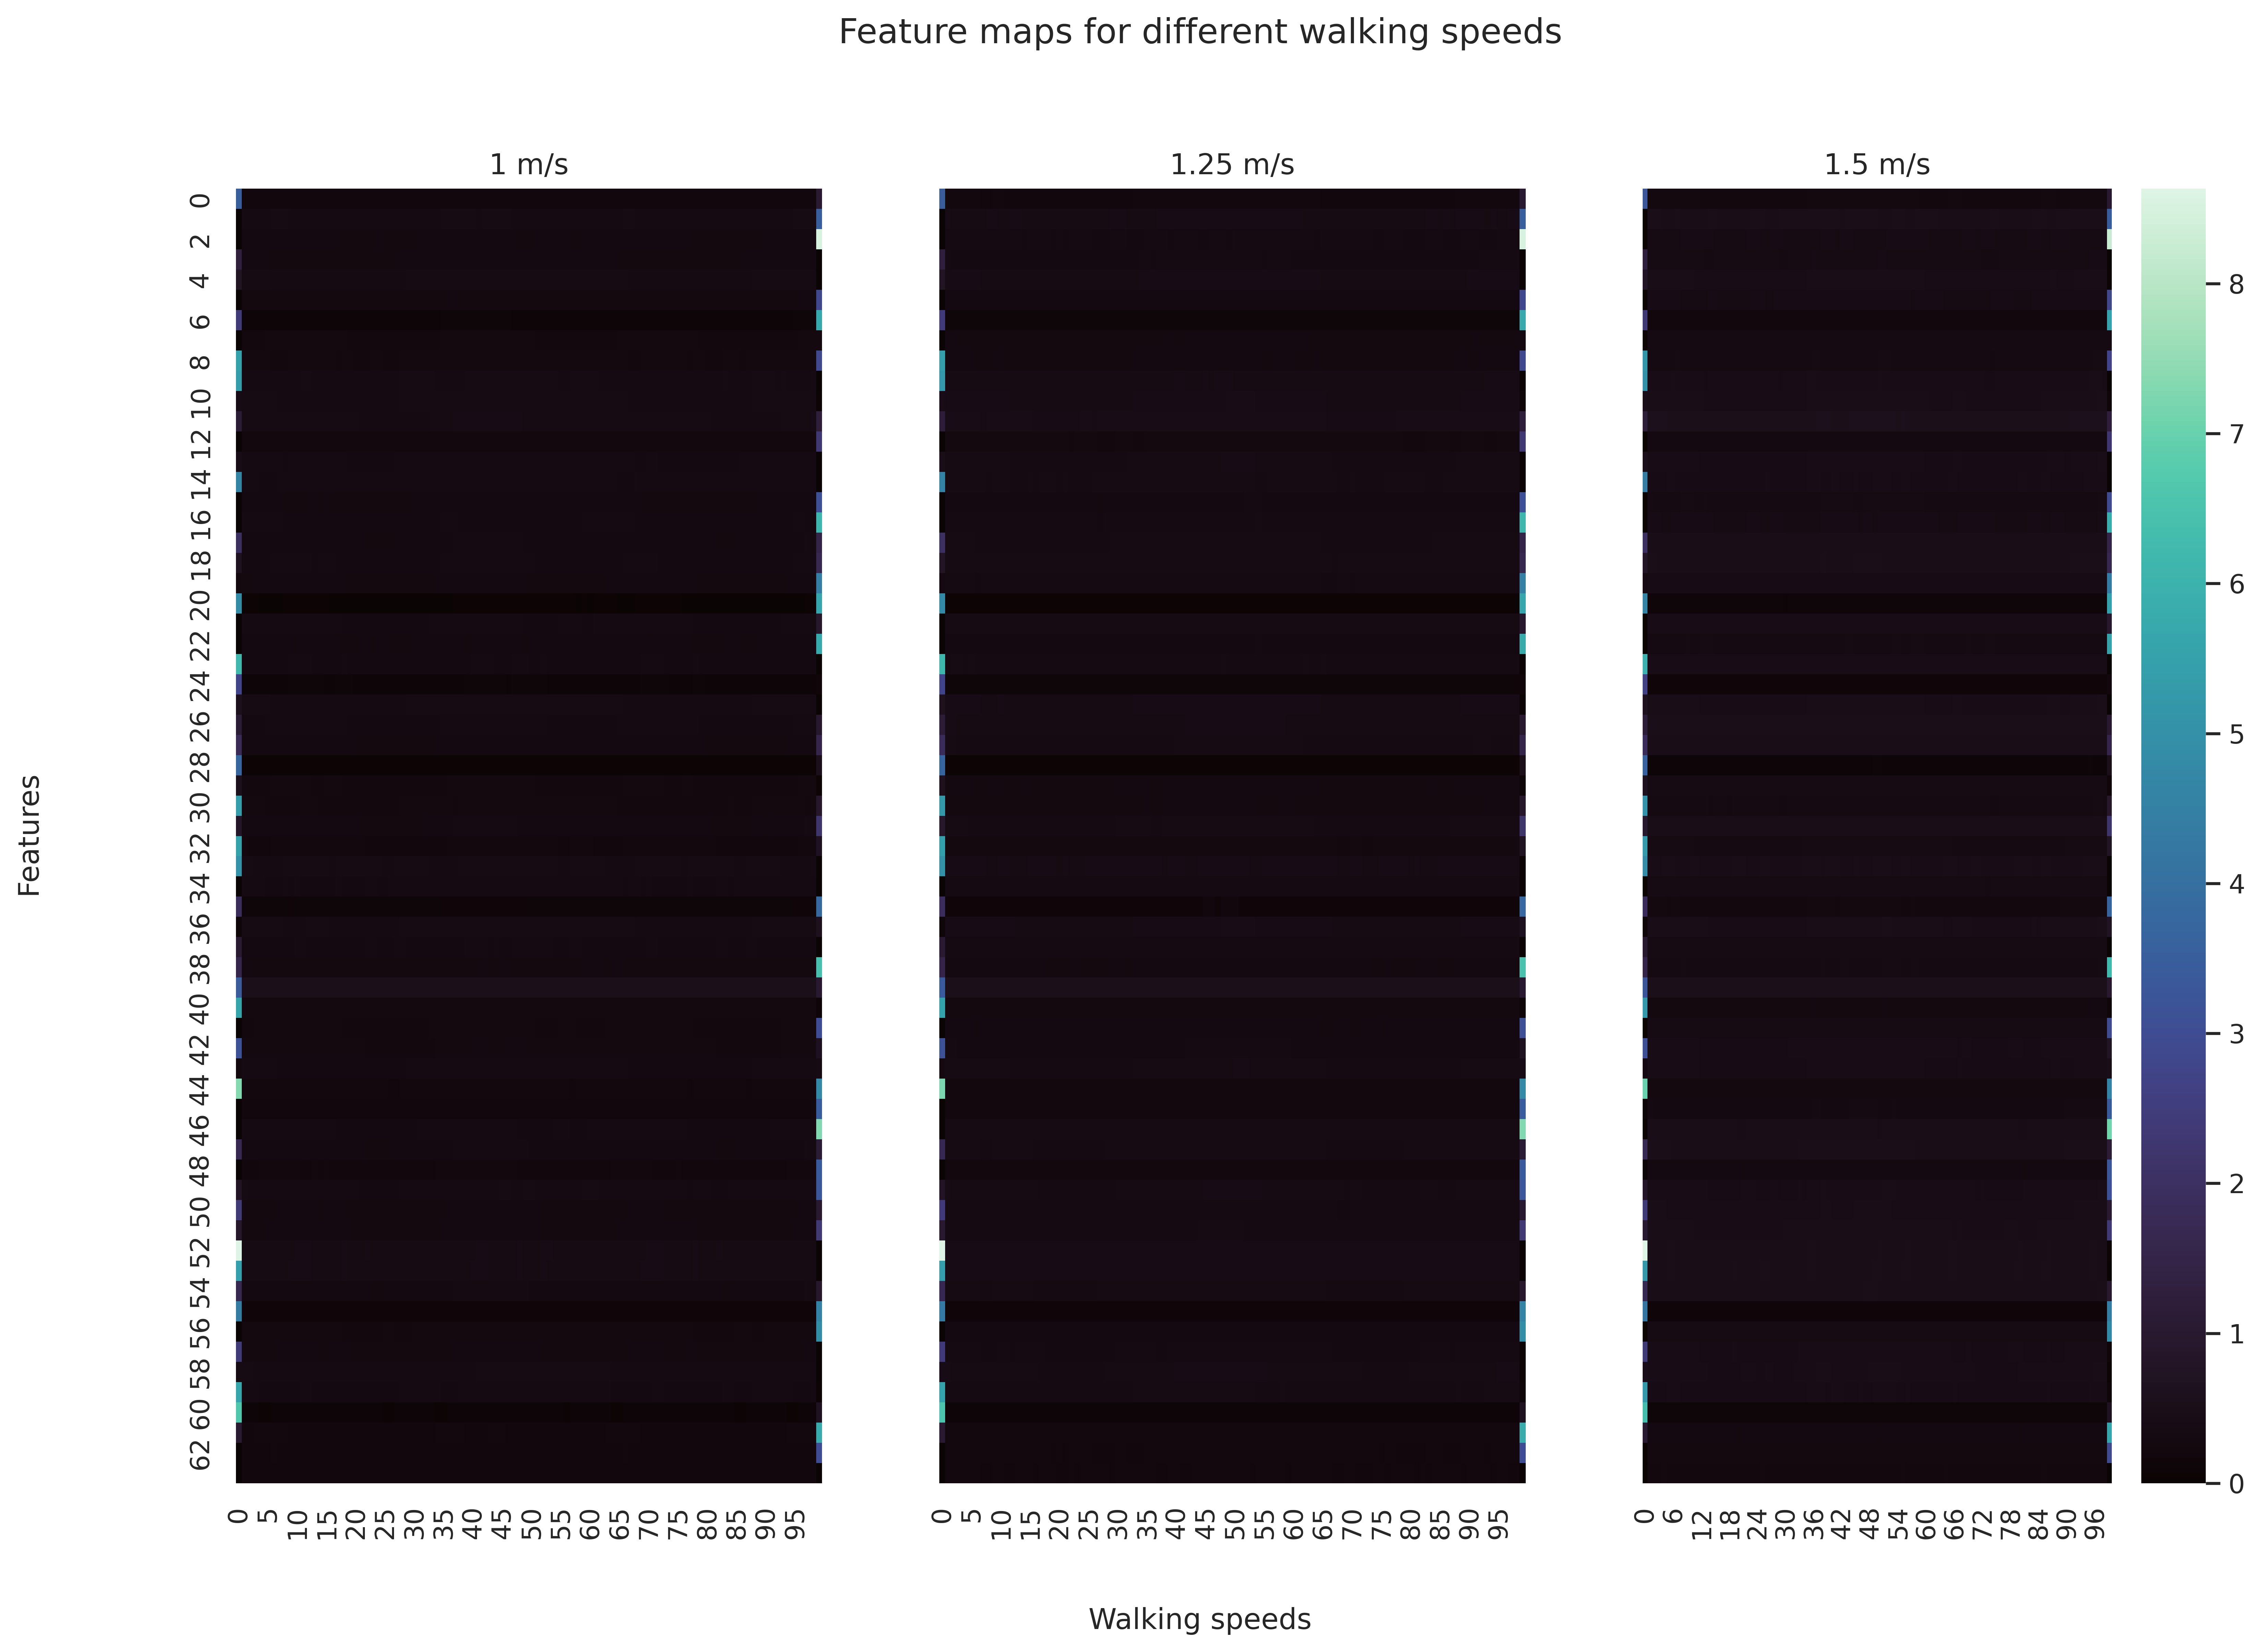

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,10),sharey=True)
colormap = sns.color_palette("mako", as_cmap=True)
fig.text(0.04, 0.5, ' Features', va='center', rotation='vertical')
fig.text(0.5,0.04,'Walking speeds',ha='center')
plt.suptitle('Feature maps for different walking speeds')
sns.set_theme(rc={"figure.dpi":500})

axes[0].set_title('1 m/s')
axes[1].set_title('1.25 m/s')
axes[2].set_title('1.5 m/s')
sns.heatmap(l1_1,cmap=colormap,ax = axes[0],vmin=0,vmax=8.5,cbar=False)
sns.heatmap(l1_2,cmap=colormap,ax = axes[1],vmin=0,vmax=8.5,cbar=False)
sns.heatmap(l1_3,cmap=colormap,ax = axes[2])
for i in range(3):
    axes[i].tick_params(left=False)

plt.savefig('../Paper_Images/SVG/Layer_1.svg')

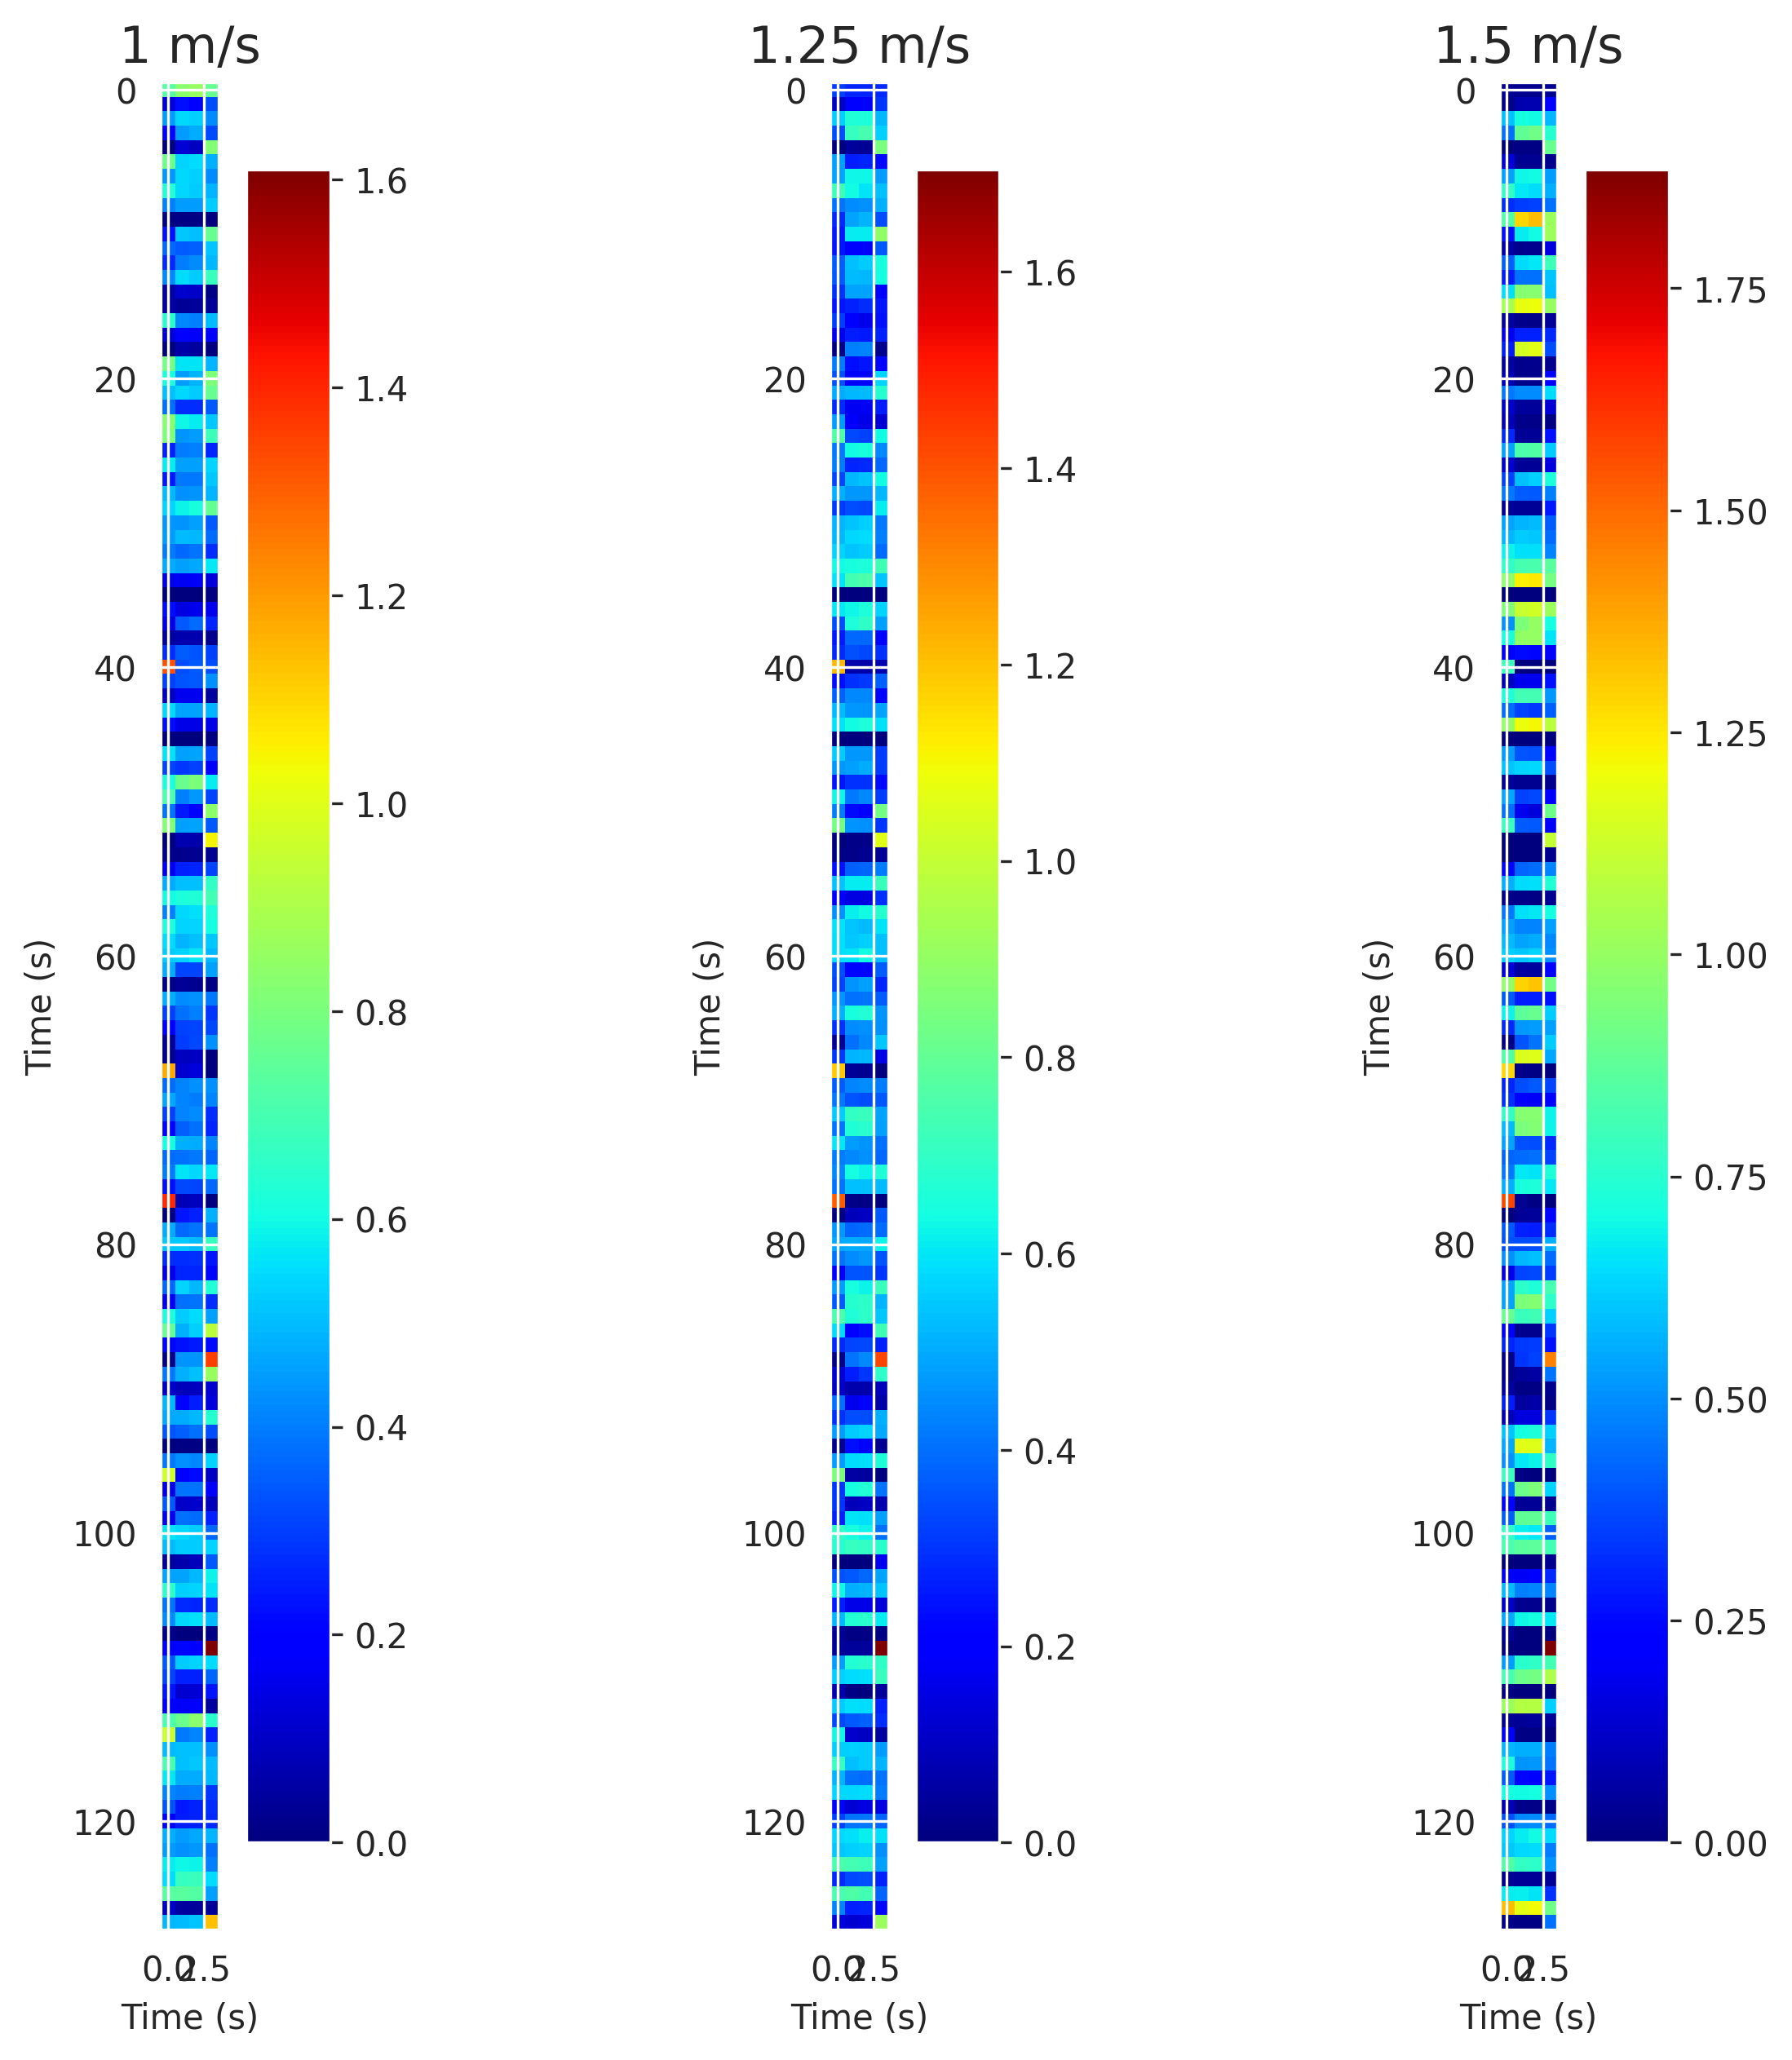

In [101]:
fig=plt.figure(figsize=(10,10),dpi=300)

ax=fig.add_subplot(1,3,1)
plt.colorbar(ax.imshow(l5_1,cmap='jet'))
ax.set_title('1 m/s')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (s)')
ax1=fig.add_subplot(1,3,2)
plt.colorbar(ax1.imshow(l5_2,cmap='jet'))
ax1.set_title('1.25 m/s')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Time (s)')
ax2=fig.add_subplot(1,3,3)
plt.colorbar(ax2.imshow(l5_3,cmap='jet'))
ax2.set_title('1.5 m/s')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Time (s)')
plt.show()

In [50]:
l1_1={'1':[],'1.25':[],'1.5':[]}
l2_1={'1':[],'1.25':[],'1.5':[]}
l3_1={'1':[],'1.25':[],'1.5':[]}
l4_1={'1':[],'1.25':[],'1.5':[]}
l5_1={'1':[],'1.25':[],'1.5':[]}

l1_1['1']=np.mean(np.array(np.array(extracted_data['1'])['1']),axis=0)
l1_1['1.25']=np.mean(np.array(extracted_data['1']['1.25']),axis=0)
l1_1['1.5']=np.mean(np.array(extracted_data['1']['1.5']),axis=0)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [39]:
d=d.drop(labels=15,axis=0)

[Text(0.5, 1.0, 'RMSE for test subjects before training')]

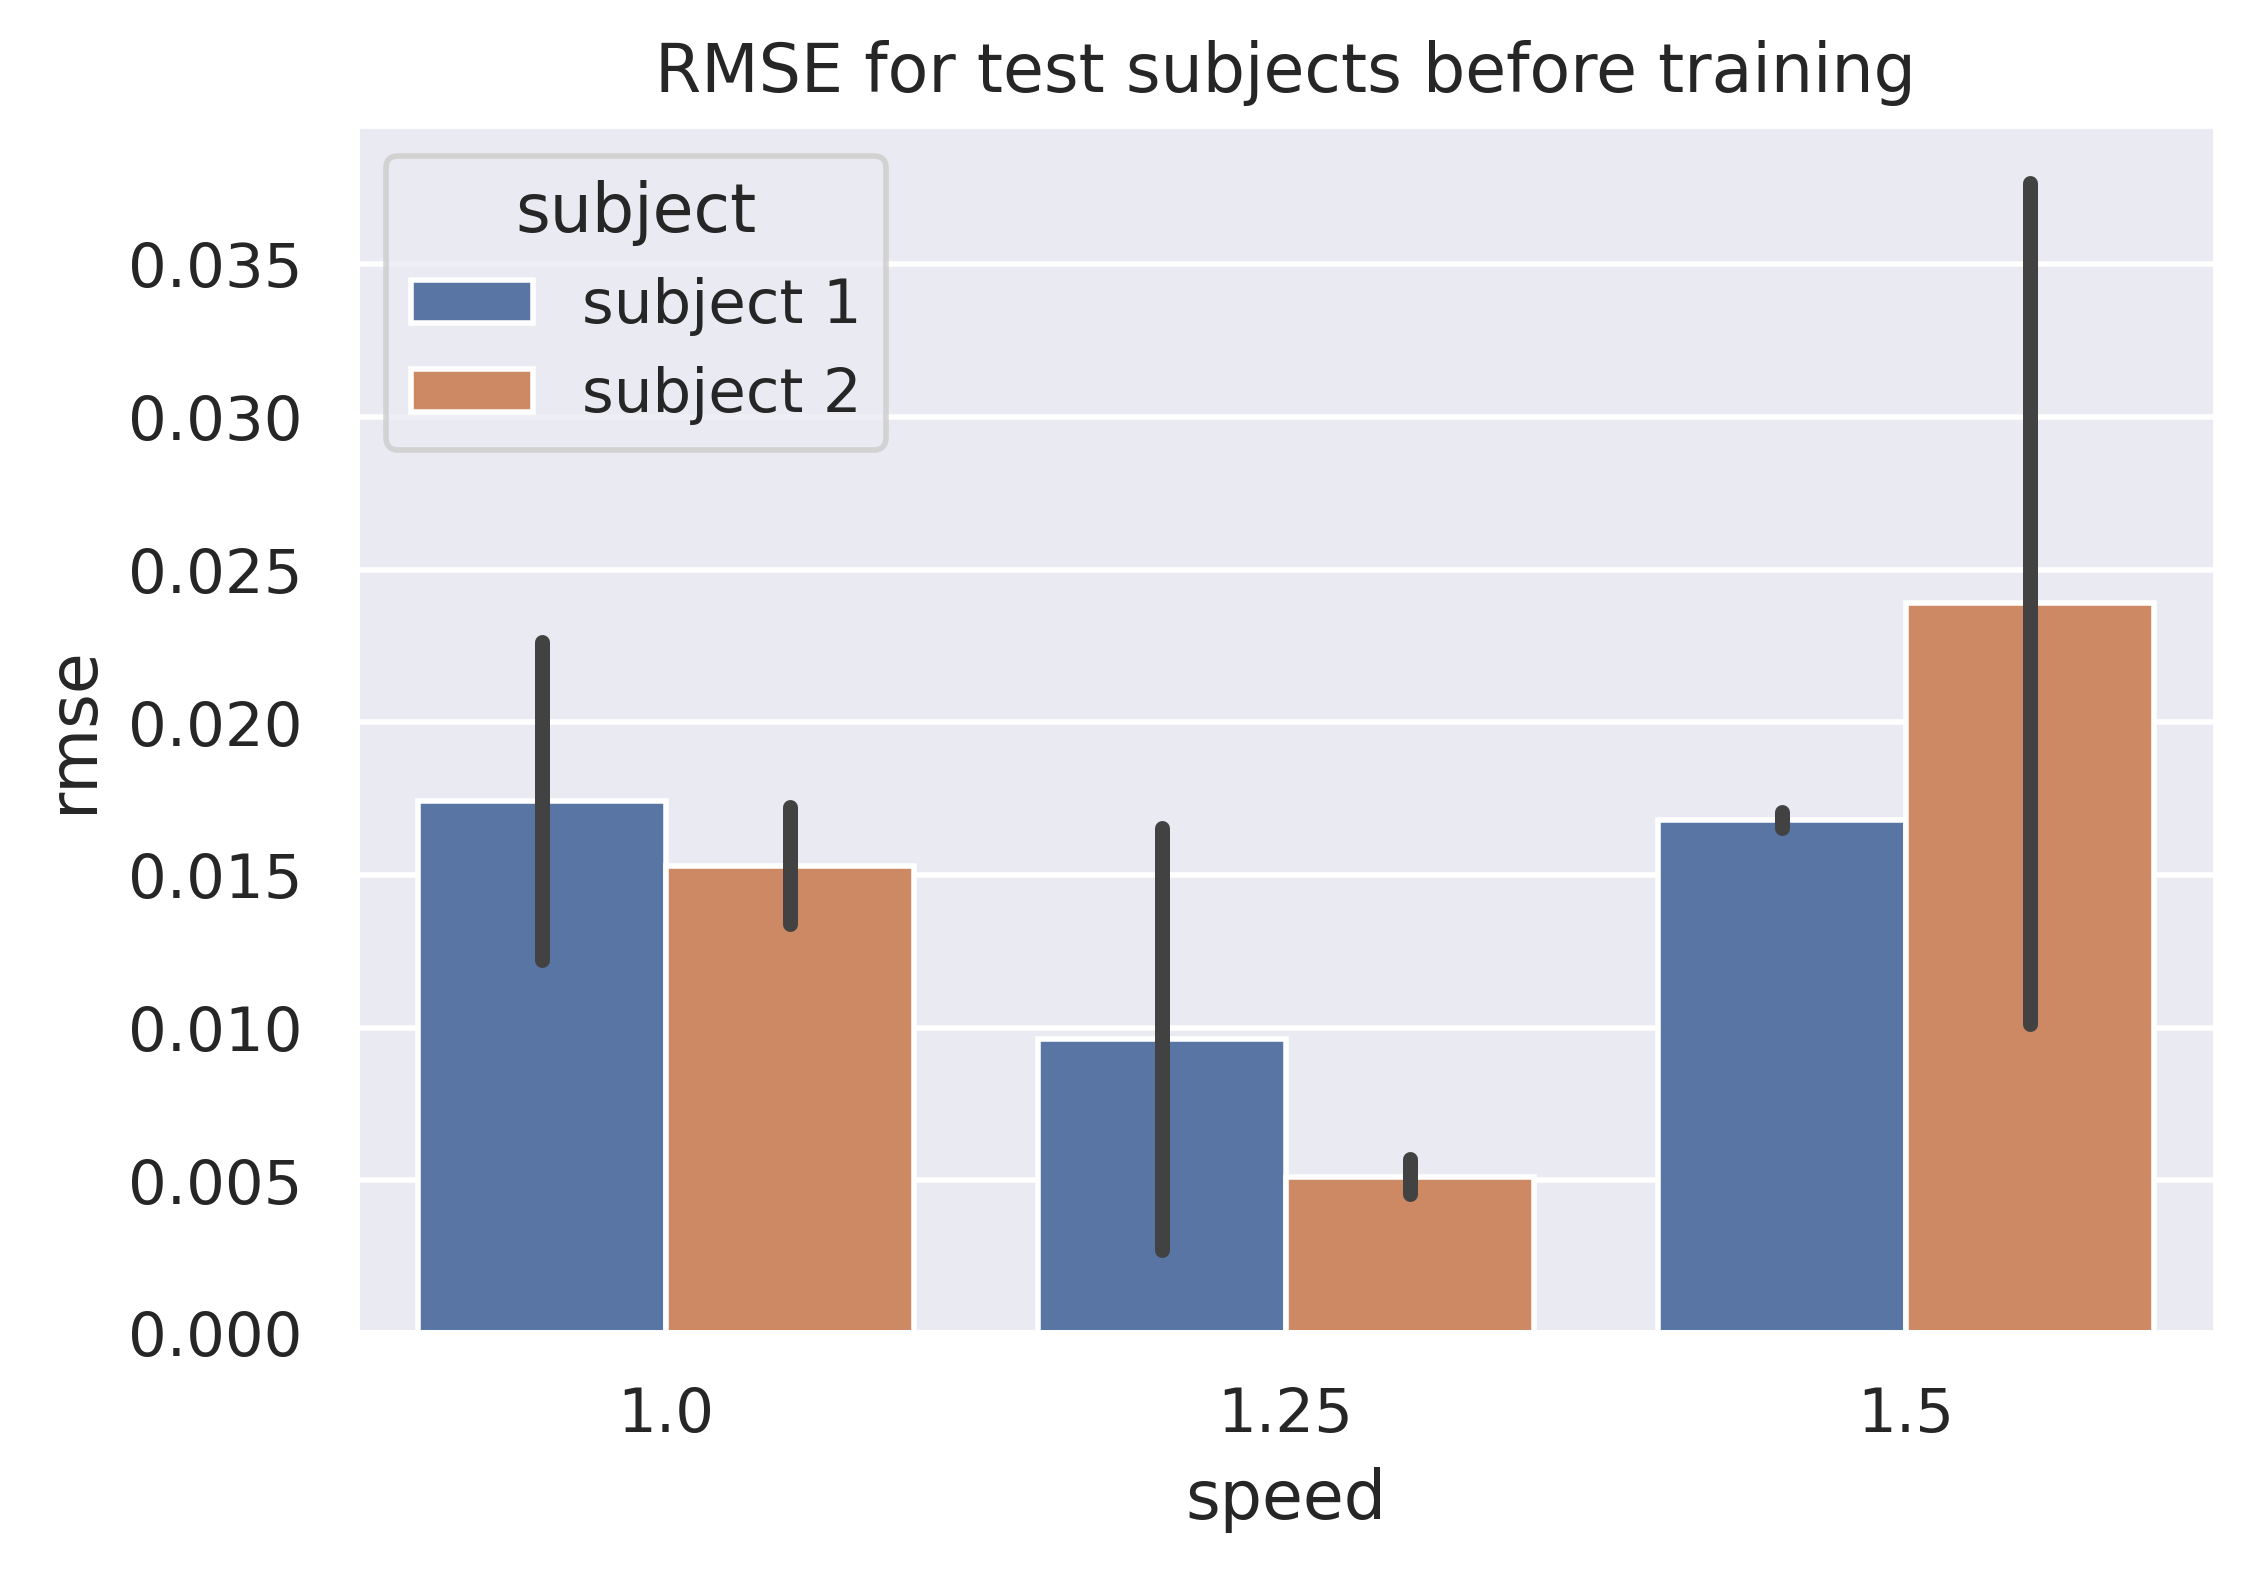

In [13]:
sns.set_theme(rc={"figure.dpi": 400})
d=pd.DataFrame(df)
sns.barplot(d,x='speed',y='rmse',hue='subject',errorbar='sd').set(title='RMSE for test subjects before training')


In [29]:
print(np.mean(rmse),np.mean(std))
print(rmse)

0.01773188893368122 0.0054571544761867355
[0.01860353956953795, 0.021098573850371116, 0.03198572781239999, 0.007097897756413651, 0.021202313691225765, 0.017616635844302123, 0.0065028372650095, 0.01774758568018967]


In [7]:
X,y=data_prep(data,1.5)

(619, 1, 200)


In [8]:
model.eval()
#X=X.reshape((-1,3,200))
#preds=[[] for i in range(len(split_data))]
#for i,v in enumerate(split_data):
#    for j,run in enumerate(v):
#        with torch.no_grad():
##            output=model.forward_run(run)
 #           preds[i].append(output.detach().cpu().numpy())
l1,l2,l3,l4,l5=[],[],[],[],[]        
preds=[]
confidences=[]
with torch.no_grad():
    for i in range(X.shape[0]):
        output=model.forward_run(X[i,:,:])
        l1.append(model.l1[0,:,:].detach().cpu().numpy())
        l2.append(model.l2[0,:,:].detach().cpu().numpy())
        l3.append(model.l3[0,:,:].detach().cpu().numpy())
        l4.append(model.l4[0,:,:].detach().cpu().numpy())
        l5.append(model.l5[0,:,:].detach().cpu().numpy())
        
        #print(output.shape)
        # 
        #_,prediction=torch.max(output.data,1)
        #confidences+=[output[:,prediction.detach().cpu()].detach().cpu()]
        preds+=output.detach().cpu()
        #preds=output.detach().cpu().numpy()
        

In [9]:
l1_a=np.mean(np.mean(l1,axis=1),axis=0)
l2_a=np.mean(np.mean(l2,axis=1),axis=0)
l3_a=np.mean(np.mean(l3,axis=1),axis=0)
l4_a=np.mean(np.mean(l4,axis=1),axis=0)
l5_a=np.mean(np.mean(l5,axis=1),axis=0)


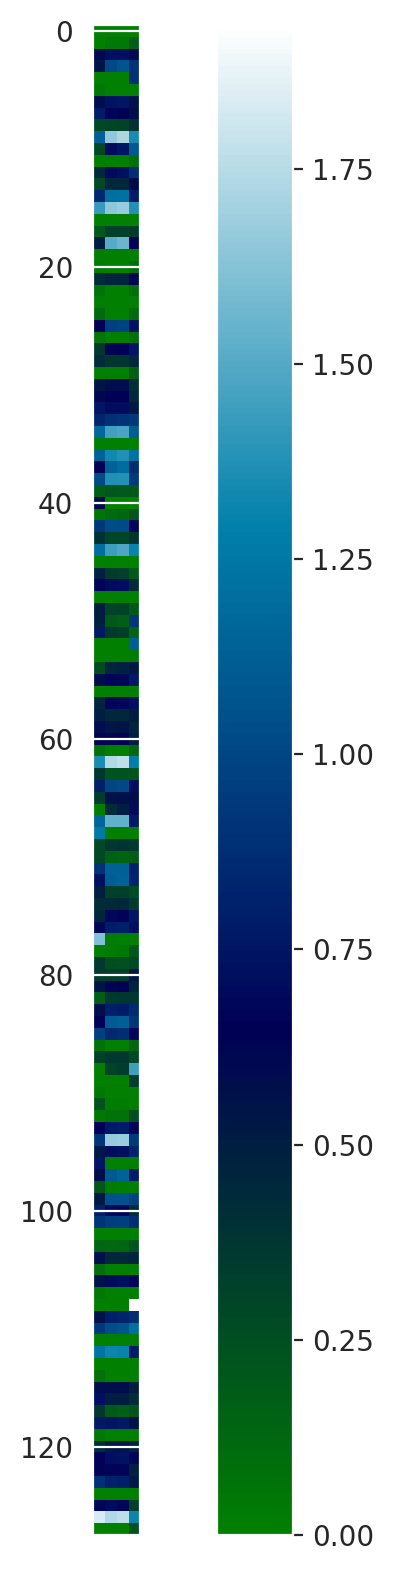

In [36]:
fig=plt.figure(figsize=(10,10),dpi=200)
ax1=fig.add_subplot(111)
ax1.imshow(l5,cmap='ocean')
ax1.set_xticks([4])
plt.colorbar(ax1.imshow(l5,cmap='ocean'))

In [65]:
features={'info':'Sub-6, run 12','l1':l1,'l2':l2,'l3':l3,'l4':l4,'l5':l5}
with open('../models/Data_based_models/CNN9/features_12.pickle','wb') as f:
    pickle.dump(features,f)

In [17]:
#for i in range(0,128,8):
#    plt.plot(model.l4[0,i,:].detach().cpu().numpy(),label=i)
#    plt.show()
#plt.legend()



In [3]:
def Kalman_1D(state,measurement,process_var=0.005**2,measurement_var=0.05**2):
        estimate=[[],[]]
        state[0],state[1]=state[0]+0,state[1]+process_var
        estimate[0],estimate[1]=(state[1]*measurement+measurement_var*state[0])/(state[1]+measurement_var),(state[1]*measurement_var)/(state[1]+measurement_var)
        state=estimate

        return state



In [31]:
print(len(preds[11][0]))

306


In [4]:
def kalman_filter(preds):
    values=[]
    for i,v in enumerate(preds):
        if i==0:
            state=[v,0.1**2]
            values+=[state[0]]
        else:
            state=Kalman_1D(state,v)
            values+=[state[0]]
    return values

In [29]:
print()

1.272546


(0.2, 2.0)

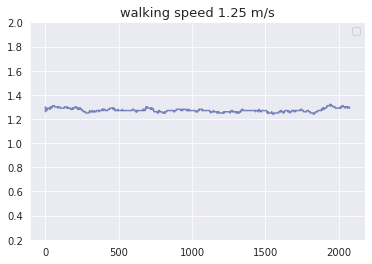

In [31]:
plt.plot(np.arange(0,len(values)/2),l_threshold(values),'b',alpha=0.5)
plt.legend([])
plt.title('walking speed 1.25 m/s')
plt.ylim([0.2,2.0])


In [33]:
print(np.sqrt(mean_squared_error(1.25*np.ones(len(values)),l_threshold(values))))

0.02732582306221878


In [10]:
insatance=SRP(h=110,
              c=1.5)
speeds=insatance.Speed_estimation_simulation(data=data[:,0],split_interval=0.5,r_number=0.25,data_flag=True)

2023-03-21 22:29:48.096 ( 161.588s) [python          ]      netinterfaces.cpp:91    INFO| netif 'lo' (status: 0, multicast: 1, broadcast: 0)
2023-03-21 22:29:48.096 ( 161.588s) [python          ]      netinterfaces.cpp:91    INFO| netif 'wlo1' (status: 4096, multicast: 1, broadcast: 2)
2023-03-21 22:29:48.096 ( 161.588s) [python          ]      netinterfaces.cpp:91    INFO| netif 'lo' (status: 0, multicast: 1, broadcast: 0)
2023-03-21 22:29:48.096 ( 161.588s) [python          ]      netinterfaces.cpp:91    INFO| netif 'wlo1' (status: 4096, multicast: 1, broadcast: 2)
2023-03-21 22:29:48.096 ( 161.588s) [python          ]      netinterfaces.cpp:102   INFO| 	IPv4 addr: a00009c
2023-03-21 22:29:48.096 ( 161.588s) [python          ]      netinterfaces.cpp:91    INFO| netif 'lo' (status: 0, multicast: 1, broadcast: 0)
2023-03-21 22:29:48.096 ( 161.588s) [python          ]      netinterfaces.cpp:91    INFO| netif 'wlo1' (status: 4096, multicast: 1, broadcast: 2)
2023-03-21 22:29:48.096 ( 161

In [42]:
for i,v in enumerate(preds):
    if v==0:
        preds[i]=1
    elif v==1:
        preds[i]=1.25
    elif v==2:
        preds[i]=1.5
    elif v==3:
        preds[i]=0.5
    elif v==4:
        preds[i]=0.75

#    if i!=0 and confidences[i]<0.98:
#        preds[i]=preds[i-1]
#pickle.dump(preds,open('preds_t.pickle','wb'))

In [50]:
print(len(sp_acc['msg']),len(values))

12 12


In [54]:
dic={'1':6,'2':3,'3':9,'4':7,'5':10,'6':2}


In [56]:
new_msg=[[] for i in range(6)]
for i in range(1,7):
    new_msg[i-1]=sp_acc['msg'][dic[f'{i}']]

In [62]:
analysys={'data':[[] for i in range(6)],'msg':[[] for i in range(6)],'avg_speed':[[] for i in range(6)],'rmse':[[] for i in range(6)],'std':[[] for i in range(6)]}
ground_truth=[1,1,1.5,1.5,1.25,1.25]

In [73]:
for i in range(6):
    for j in range(len(new_values[i])):
        print(analysys['rmse'][i][j])
        print(analysys['std'][i][j])
        print(analysys['avg_speed'][i][j])
        print(analysys['msg'][i][j])
        input('dfgg')

0.40915072027633953
0.006761811363600054
0.5909051579282248
Start : Standing : 
0.022619782712182766
0.0058126700831607914
0.9781398207589533
Start : Standing : 
0.012224995711295586
0.009584405271418194
0.9924112124990612
Start : Walking : 2.2
0.03138969937329332
0.014296632090141584
1.0279449376028085
Start : Walking : 2.2 powered 
0.20104393669550485
0.014967672787671598
1.2004859926612015
Start : Walking : 2.2 powered wider stance
0.025279531762052176
0.015397853701279763
1.0200489607586676
Start : Walking : 2.2 powered higher step frequency
0.05353653288366153
0.02227300205037587
1.0486834030534773
Start : Walking : 2.2 powered lower step frequency
0.08599822998376143
0.02370035973924193
1.082667941238248
Start : Walking : 2.2 powered looking strainght
0.016684610884394907
0.008466370391555659
1.0143769542239187
Start : Walking : 2.2 swing arms more
0.41068549586762076
0.013043631276038074
0.5895216933878621
Start : Walking : 2.2 Normal Walking
0.4043390815646508
0.003606934392720

KeyboardInterrupt: Interrupted by user

In [78]:
i=2
j=4
print(analysys['rmse'][i][j])
print(analysys['std'][i][j])
print(analysys['avg_speed'][i][j])
print(analysys['msg'][i][j])
        

0.017720727191129788
0.003941779036933706
1.4954750670576196
Start : powered walking looking straight 3.3


(0.0, 2.0)

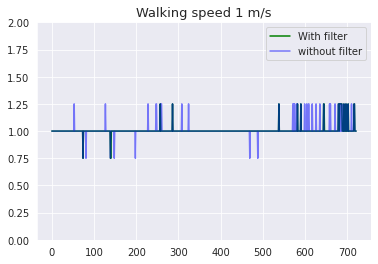

In [43]:
preds1=pickle.load(open('preds_t.pickle','rb'))

plt.plot(preds1,'g')
plt.plot(preds,'b',alpha=0.5)
plt.legend(['With filter','without filter'])
plt.title('Walking speed 1 m/s')
plt.ylim(0,2)

In [24]:
def get_speeds(preds,confidences,threshold=0.8):

    if i!=0 and confidences[i]<threshold:
        preds[i]=preds[i-1]

    return preds

In [96]:
def get_speed(preds1,confidences,threshold):
    pred=[]
    for i,v in enumerate(preds1):
        if v==0:
            pred.append(1)
        elif v==1:
            pred.append(1.25)
        elif v==2:
            pred.append(1.5)
        elif v==3:
            pred.append(0.5)
        elif v==4:
            pred.append(0.75)
        
        if i!=0 and confidences[i]<threshold:
            pred[i]=preds1[i-1]
    return pred

In [106]:
preds1=get_speed(preds,confidences,0.5)
pred2=get_speed(preds,confidences,0.6)
pred3=get_speed(preds,confidences,0.7)
pred4=get_speed(preds,confidences,0.8)
pred5=get_speed(preds,confidences,0.9)
pred6=get_speed(preds,confidences,0.95)
pred7=get_speed(preds,confidences,0.98)


(0.0, 2.5)

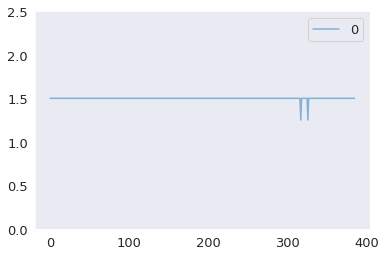

In [110]:
#plt.plot(preds1,alpha=0.5)
#plt.plot(pred2)
#plt.plot(pred3)
#plt.plot(pred4)
#plt.plot(pred5,alpha=0.5)
#plt.plot(pred6,alpha=0.5)
#plt.plot(pred7,alpha=0.5)
plt.plot(get_speed(preds,confidences,0),alpha=0.5)
plt.legend(['0'])
plt.ylim(0,2.5)

In [11]:
def threshold(x,a=0.01):
    return np.round(np.round(x/a)*a,3)

def l_threshold(l,a=0.01):
    return [threshold(x,a) for x in l]

(0.2, 2.0)

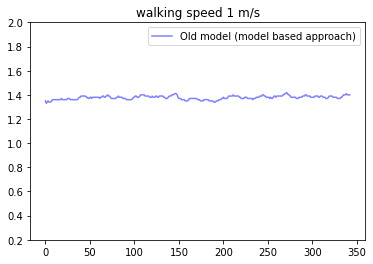

In [15]:
#plt.plot(speeds['Double'],'g',alpha=0.5)
plt.plot(l_threshold(values),'b',alpha=0.5)
plt.legend(['Old model (model based approach)','new model'])
plt.title('walking speed 1 m/s')
plt.ylim([0.2,2.0])


In [10]:
mse=mean_squared_error(1.25*np.ones(len(values[50:])),l_threshold(values[50:]))
print(mse)
print(np.sqrt(mse))
print(np.std(values))
print(np.mean(l_threshold(values)))

0.005829719750414358
0.07635260146461519
0.038497873
1.3134017


In [42]:
confidenc_list=np.arange(0.8,1.0,0.02)
labels,outputs=[],[]

for h in confidenc_list:
    lab=[]
    out=[]
    for i in range(2,9):
        d=pickle.load(open(f'../Recordings/sub-P005/pickled_data/{i}.pickle','rb'))
        data=d['data']
        label=d['label']
        X,Y=split(data,label
            ,window=0.5,sample_rate=200,vert_acc_i=0,interval=0.3)
    #test_dataset=IMU(X,Y,size=400,num_features=6)
    #test_loader=DataLoader(test_dataset,batch_size=1)
        X=X.reshape(X.shape[0],X.shape[1]*X.shape[2])
        X=norm.fit_transform(X)
        X=X.reshape(X.shape[0],3,100)
        print(X.shape)
        model.eval()
        X=X.reshape((-1,3,100))
        preds=[]
        confidences=[]
        with torch.no_grad():
            for j in range(X.shape[0]):
                output=model.forward_run(X[j,:,:])
                #print(output.shape)
                _,prediction=torch.max(output.data,1)
                confidences+=[output[:,prediction.detach().cpu()].detach().cpu()]
                preds+=prediction.detach().cpu()
                #preds=output.detach().cpu().numpy()
        preds=get_speeds(preds,confidences,threshold=h)
        lab+=[label for i in range(len(preds))]
        out+=preds

    labels.append(lab)
    outputs.append(out)

        
    
    
    


(649, 3, 100)
(722, 3, 100)
(675, 3, 100)
(670, 3, 100)
(688, 3, 100)
(653, 3, 100)
(538, 3, 100)
(649, 3, 100)
(722, 3, 100)
(675, 3, 100)
(670, 3, 100)
(688, 3, 100)
(653, 3, 100)
(538, 3, 100)
(649, 3, 100)


KeyboardInterrupt: 

In [30]:
from sklearn.metrics import classification_report
class_reports=[]
for i in range(len(confidenc_list)):
    
    class_reports.append(classification_report(labels[i],outputs[i],output_dict=True))



/home/prestige/Documents/venvs/activity_class/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prestige/Documents/venvs/activity_class/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prestige/Documents/venvs/activity_class/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

{'0': {'precision': 0.9439912996193583, 'recall': 0.9093766369827134, 'f1-score': 0.9263607257203842, 'support': 1909}, '1': {'precision': 0.8776758409785933, 'recall': 0.8535315985130112, 'f1-score': 0.8654353562005278, 'support': 1345}, '2': {'precision': 0.9291784702549575, 'recall': 0.9783743475018642, 'f1-score': 0.9531420268797676, 'support': 1341}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.9131664853101197, 'macro avg': {'precision': 0.5501691221705818, 'recall': 0.5482565165995178, 'f1-score': 0.5489876217601359, 'support': 4595}, 'weighted avg': {'precision': 0.920257176431221, 'recall': 0.9131664853101197, 'f1-score': 0.9163431202471582, 'support': 4595}}


/home/prestige/Documents/venvs/activity_class/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prestige/Documents/venvs/activity_class/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prestige/Documents/venvs/activity_class/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

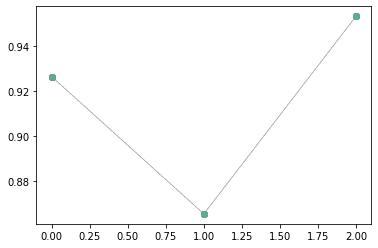

In [29]:
for i in range(10):
    l=[class_reports[i]['0']['f1-score'],class_reports[i]['1']['f1-score'],class_reports[i]['2']['f1-score']]
    plt.plot(l,'o--',alpha=0.5,linewidth=0.2)
    
#plt.legend(confidenc_list)

# Augment the data with some noise


In [43]:
run=4
path=f'../Recordings/sub-P004/pickled_data/{run}.pickle'

with open(path,'rb') as f:
    d=pickle.load(f)
    print('here')
    

data=d['data']


here


In [8]:
noise_x=np.random.normal(0,5,(data.shape[0],1))
noise_y=np.random.normal(15,10,(data.shape[0],1))
noise_z=np.random.normal(0,5,(data.shape[0],1))

In [9]:

augmented_data_x=data[:,0]+noise_x[:,0]
augmented_data_y=data[:,1]+noise_y[:,0]
augmented_data_z=data[:,2]+noise_z[:,0]

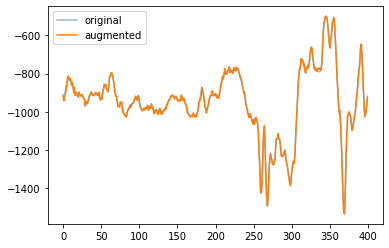

In [7]:
plt.plot(data[:400,0],alpha=0.5)
plt.plot(augmented_data[:400])
plt.legend(['original','augmented'])

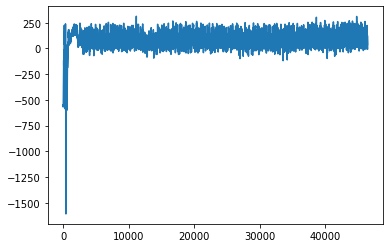

In [18]:
plt.plot(data[:,2])

In [13]:
print(np.mean(data,axis=0))

[-997.9253     11.262003   92.11954 ]


In [59]:
print(np.mean(data,axis=0))
print(np.mean(augmented_data,axis=0))

[-943.1897     25.928131  287.65912 ]
[-943.19967183   25.9577703   287.63827827]


In [26]:

for i in range(2,23):
    path=f'../Recordings/sub-P005/pickled_data/{i}.pickle'
    with open(path,'rb') as f:
        d=pickle.load(f)
        print('here')
    data=d['data']
    noise_x=np.random.normal(0,4,(data.shape[0],1))
    noise_y=np.random.normal(np.random.randint(-30,30),15,(data.shape[0],1))
    noise_z=np.random.normal(0,10,(data.shape[0],1))
    augmented_data=np.empty((data.shape[0],3))
    augmented_data[:,0]=data[:,0]+noise_x[:,0]
    augmented_data[:,1]=data[:,1]+noise_y[:,0]
    augmented_data[:,2]=data[:,2]+noise_z[:,0]
    d['data']=augmented_data
    save_path=f'../Recordings/sub-P005/aug_data/{i}_augmented.pickle'
    with open(save_path,'wb') as f:
        pickle.dump(d,f)     

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here


Text(0.5, 1.0, 'Y axis data with noise')

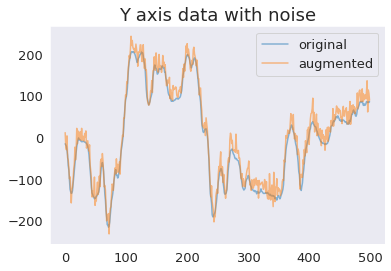

In [51]:
run=4
path=f'../Recordings/sub-P004/aug_data/{run}_augmented.pickle'

with open(path,'rb') as f:
    d=pickle.load(f)
    print('here')
d=d['data']
plt.plot(data[500:1000,1],alpha=0.5)
plt.plot(d[500:1000,1],alpha=0.5)
plt.legend(['original','augmented'])
plt.title('Y axis data with noise')

In [3]:
noise=np.random.normal(0,5,(500,1))

In [3]:
data=pickle.load(open('../models/Data_based_models/CNN9/history.pickle','rb'))

print(data.keys())

history={'train_loss':[[] for i in range(5)],'train_acc':[[] for i in range(5)],'val_loss':[[] for i in range(5)],'val_acc':[[] for i in range(5)],'labels':[[] for i in range(5)],'outputs':[[] for i in range(5)]}

dict_keys(['train_loss', 'test_loss', 'train_acc', 'test_acc', 'labels', 'outputs'])


In [4]:
j=0
for i in range(len(data['train_loss'])):
    
    history['train_loss'][j].append(data['train_loss'][i])
    history['train_acc'][j].append(data['train_acc'][i])
    history['val_loss'][j].append(data['test_loss'][i])
    history['val_acc'][j].append(data['test_acc'][i])
    history['labels'][j].append(data['labels'][i])
    history['outputs'][j].append(data['outputs'][i])
    if (i+1)%40==0 and i!=0:
        j+=1


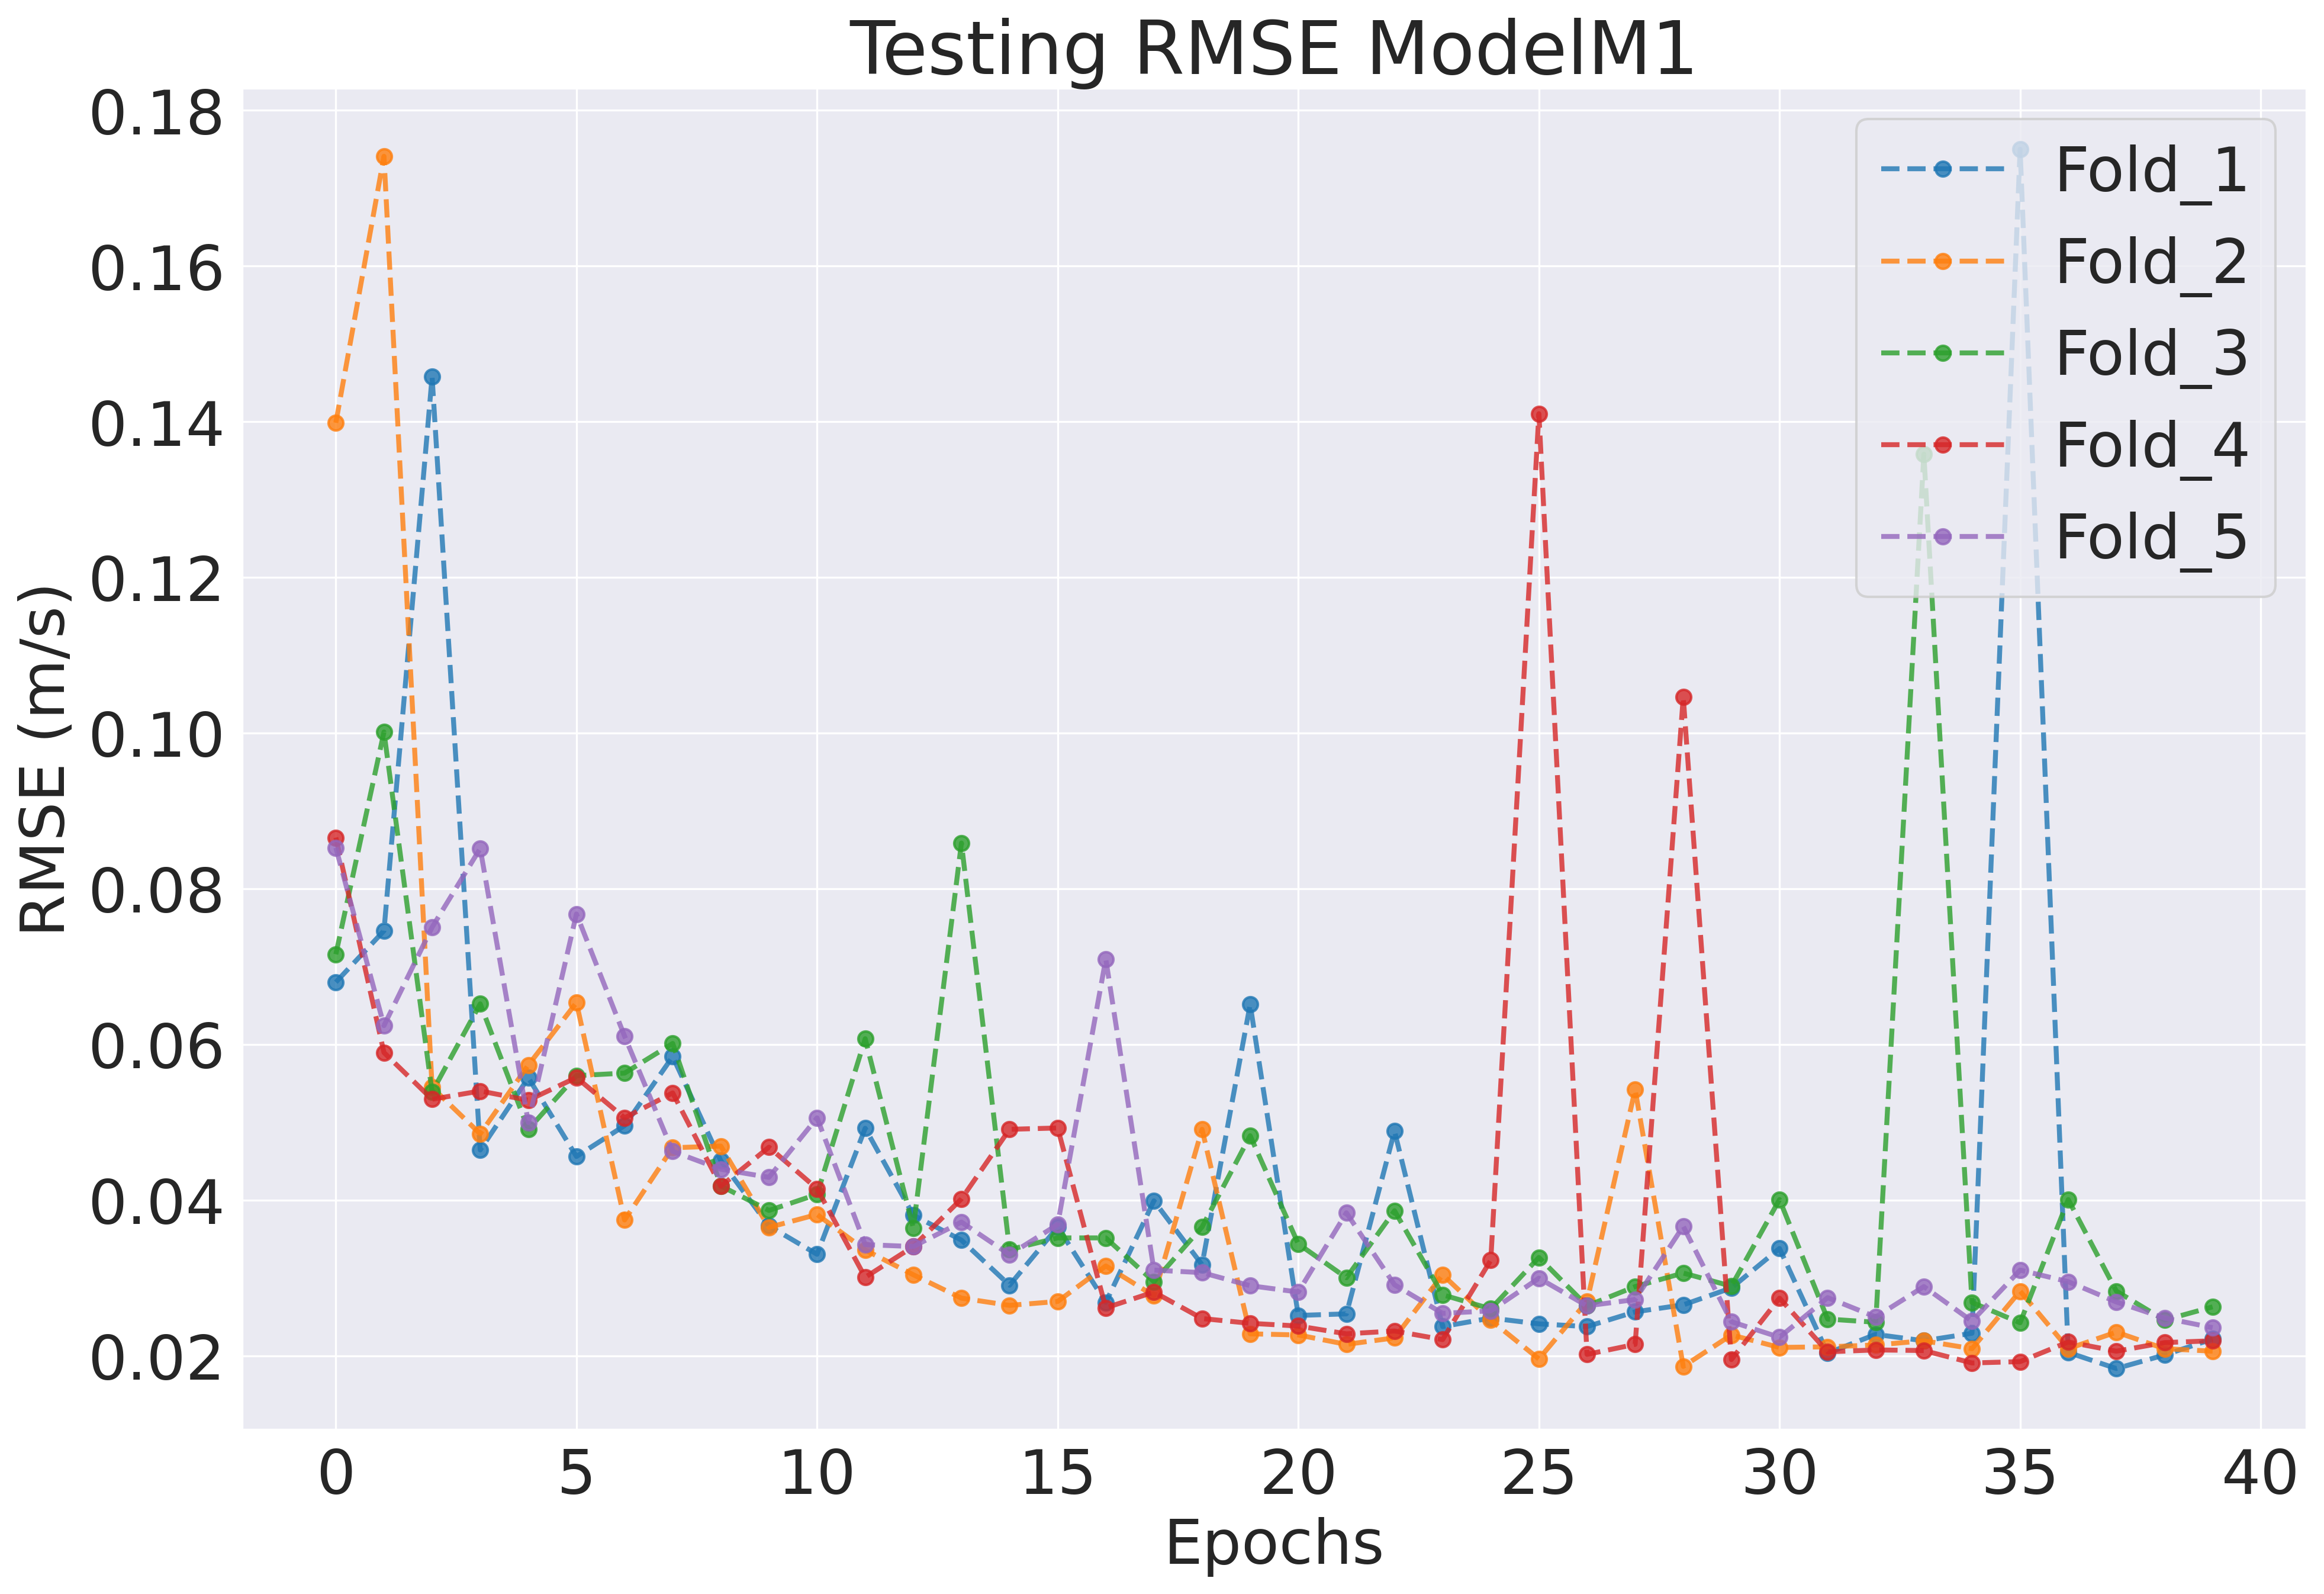

In [8]:
fig=plt.figure(figsize=(15,10),dpi=300)
ax=fig.add_subplot(111)
minimums=[]
for i in range(5):
    #rmse=[np.sqrt(history['train_loss'][i][j]) for j in range(0,len(history['train_loss'][i]))]
    rmse=[np.sqrt(mean_squared_error(history['labels'][i][j],history['outputs'][i][j])) for j in range(0,len(history['labels'][i]))]
    minimums.append(np.min(rmse))
    ax.plot(rmse,'o--',alpha=0.8,linewidth=2)
    ax.legend(['Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'],loc='upper right')
    ax.set_title('Testing RMSE ModelM1')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('RMSE (m/s)')

In [11]:
fig.savefig('../Paper_Images/SVG/rsme.svg',format='svg')

In [11]:
print(minimums)

[0.029277579092250025, 0.031153781400311404, 0.02936274675591281, 0.03720752781525918, 0.035235296107095374]


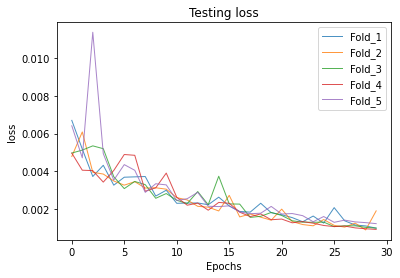

In [78]:
for i in range(5):
    plt.plot(history['val_loss'][i][:],'-',alpha=0.8,linewidth=1)
    plt.legend(['Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'],loc='best')
    plt.title('Testing loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')

In [39]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('font', size=10)          # controls default text sizes

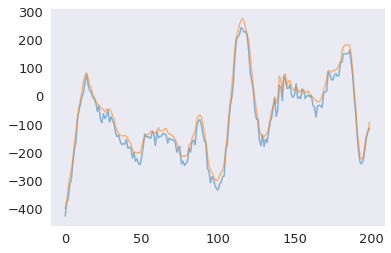

In [71]:
data1=pickle.load(open("../Recordings/sub-P003/aug_data/1_augmented.pickle","rb"))
data2=pickle.load(open("../Recordings/sub-P003/pickled_data/1.pickle","rb"))

plt.plot(data1['data'][1000:1200,1],alpha=0.5)
plt.plot(data2['data'][1000:1200,1],alpha=0.5)

In [77]:
data,header=xdf.load_xdf("../Recordings/Testing/sub-P004/sub-test1_ses-S001_task-Default_run-004_eeg.xdf")

for stream in data:
    #print(stream['info']['name'][0])
    if stream['info']['name'][0]=='classification':
        print('here')
        speeds=stream['time_series']
    if stream['info']['name'][0]=='old':
        print('here')
        old=stream['time_series']
        print('old')


here
here
old


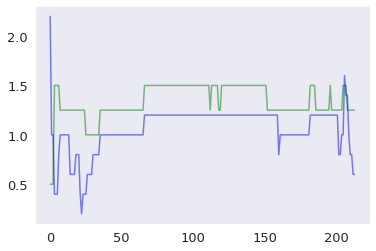

In [78]:
plt.plot(speeds,'g',alpha=0.5)
plt.plot(old,'b',alpha=0.5)

In [25]:
g=np.ones((100,100,100))
print(g[0:1])

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]


In [67]:
with open('../models/Data_based_models/CNN9/features_10.pickle','rb') as f:
    data_10=pickle.load(f)
with open('../models/Data_based_models/CNN9/features_11.pickle','rb') as f:
    data_11=pickle.load(f)
with open('../models/Data_based_models/CNN9/features_12.pickle','rb') as f:
    data_12=pickle.load(f)

In [68]:
l1_10=data_10['l1']
l2_10=data_10['l2']
l3_10=data_10['l3']
l4_10=data_10['l4']
l5_10=data_10['l5']

l1_11=data_11['l1']
l2_11=data_11['l2']
l3_11=data_11['l3']
l4_11=data_11['l4']
l5_11=data_11['l5']

l1_12=data_12['l1']
l2_12=data_12['l2']
l3_12=data_12['l3']
l4_12=data_12['l4']
l5_12=data_12['l5']

In [97]:
print(np.mean(np.std(l1_10,axis=1),axis=0).shape)

(100,)


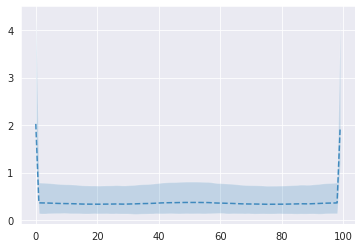

In [102]:
layer=l1_11
plt.plot(np.mean(np.mean(layer,axis=1),axis=0),'--',alpha=0.8)
plt.fill_between(np.arange(0,np.array(layer).shape[2]),np.mean(np.mean(layer,axis=1),axis=0)-np.std(np.std(layer,axis=1),axis=0),np.mean(np.mean(layer,axis=1),axis=0)+np.mean(np.std(layer,axis=1),axis=0),alpha=0.2)

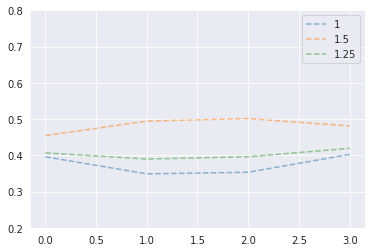

In [94]:
plt.plot(np.mean(np.mean(l5_10,axis=1),axis=0),'--',alpha=0.5,label='1')
plt.plot(np.mean(np.mean(l5_11,axis=1),axis=0),'--',alpha=0.5,label='1.5')
plt.plot(np.mean(np.mean(l5_12,axis=1),axis=0),'--',alpha=0.5,label='1.25')
plt.ylim([0.2,0.8])
plt.legend()
plt.show()

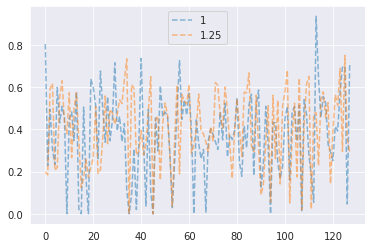

In [89]:
plt.plot(np.mean(np.mean(l5_10,axis=2),axis=0),'--',alpha=0.5,label='1')
#plt.plot(np.mean(np.mean(l5_11,axis=2),axis=0),'--',alpha=0.5,label='1.5')
plt.plot(np.mean(np.mean(l5_12,axis=2),axis=0),'--',alpha=0.5,label='1.25')
#plt.ylim([0.2,0.8])
plt.legend()
plt.show()